In [1]:
# import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import cv2
import math
import torch
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import matplotlib.colorbar as colorbar

import requests
from io import BytesIO
from PIL import Image
import numpy as np
from maskrcnn_benchmark.utils import cv2_util
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from moviepy.editor import VideoFileClip

# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20*1.5, 12*1.5

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.structures.keypoint import keypoints_to_heat_map
from maskrcnn_benchmark.modeling.roi_heads.keypoint_head.loss import project_keypoints_to_heatmap
from predictor import COCODemo

In [2]:
def load(img_path):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    pil_image = Image.open(img_path).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def load_video(video_path,frame_id=[0]):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    video_clip = VideoFileClip(video_path)
    if frame_id is None:
        nframes = int(video_clip.fps * video_clip.duration)
        frame_id = range(nframes)
    images = []
    for i in frame_id:
        image = video_clip.get_frame(i/video_clip.fps)
        # convert to BGR format
        image = np.array(image)[:, :, [2, 1, 0]]
        images += [image]
    video_clip.close()
    
    return images

def imshow(img):
    plt.gca().invert_yaxis()
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    
def sigmoid(x):
  return 1 / (1 + math.exp(-x))
# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# num keypoints per animal, heatmap
def calculate_peaks(numparts, heatmap_avg):
    score = np.ones((numparts,)) * 0.000001
    all_peaks = []
    peak_counter = 0
    if len(score) < numparts:
        score = score[:numparts]
        print("score", score)
        ##logger.ERROR(‘Not enough scores provided for number of parts’)
        # return
    # threshold_detection = params[‘thre1’]
    # tic_localmax=time.time()
    for part in range(numparts):
        map_ori = heatmap_avg[part, :, :]
        map = map_ori
        map_left = np.zeros(map.shape)
        map_left[1:, :] = map[:-1, :]
        map_right = np.zeros(map.shape)
        map_right[:-1, :] = map[1:, :]
        map_up = np.zeros(map.shape)
        map_up[:, 1:] = map[:, :-1]
        map_down = np.zeros(map.shape)
        map_down[:, :-1] = map[:, 1:]
        #peaks_binary = np.logical_and(np.logical_and(np.logical_and(map >= map_left, map >= map_right),
                                                     #np.logical_and(map >= map_up, map >= map_down)), map > score[part])
        peaks_binary = (sigmoid_v(map_ori) > .2)
        #print("pb shap", np.shape(peaks_binary))
        peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
        peaks_with_score_and_id = [x + (map_ori[x[1], x[0]], i + peak_counter,) for i, x in
                                   enumerate(peaks)]  # if x[0]>0 and x[1]>0 ]
        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks)
    return all_peaks



In [3]:
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'jet',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 10, # was 10
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    #'text.usetex': True,
    'figure.figsize': [20, 12],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

In [4]:
def overlay_keypoints(image, predictions):
        #keypoints = predictions.get_field("keypoints")
        kps = predictions#keypoints.keypoints
        scores = kps.new_ones((kps.size(0), kps.size(1)))
        kps = torch.cat((kps[:, :, 0:2], scores[:, :, None]), dim=2).numpy()
        for region in kps:
            kfun = BeeKeypoints
            image = vis_keypoints_others(
                    image,
                    region.transpose((1, 0)),
                    kp_thresh=0,
                    kfun=kfun)
                
        return image


In [5]:
import cv2
import torch
from torchvision import transforms as T

from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.modeling.roi_heads.mask_head.inference import Masker
from maskrcnn_benchmark import layers as L
from maskrcnn_benchmark.utils import cv2_util

import numpy as np
import matplotlib.pyplot as plt
from maskrcnn_benchmark.structures.keypoint import PersonKeypoints, BeeKeypoints, FlyKeypoints


def vis_keypoints_others(img, kps, kp_thresh=2, alpha=0.7, kfun=PersonKeypoints):
    """Visualizes keypoints (adapted from vis_one_image).
    kps has shape (4, #keypoints) where 4 rows are (x, y, logit, prob).
    """
    img = img.copy()
    dataset_keypoints = kfun.NAMES
    kp_lines = kfun.CONNECTIONS

    # Convert from plt 0-1 RGBA colors to 0-255 BGR colors for opencv.
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(kp_lines) + 2)]
    colors = [(c[2] * 255, c[1] * 255, c[0] * 255) for c in colors]

    # Perform the drawing on a copy of the image, to allow for blending.
    kp_mask = np.copy(img)
    
    # Draw the keypoints.
    for l in [0]:#range(len(kp_lines)):
        i1 = kp_lines[l][0]
        i2 = kp_lines[l][1]
        p1 = kps[0, i1], kps[1, i1]
        p2 = kps[0, i2], kps[1, i2]
        #if kps[2, i1] > kp_thresh and kps[2, i2] > kp_thresh:
         #   cv2.line(
          #      kp_mask, p1, p2,
           #     color=colors[l], thickness=2, lineType=cv2.LINE_AA)
        if kps[2, i1] > kp_thresh:
            cv2.circle(
                kp_mask, p1,
                radius=16, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)
        #if kps[2, i2] > kp_thresh:
         #   cv2.circle(
          #      kp_mask, p2,
           #     radius=16, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)

    # Blend the keypoints.
    return cv2.addWeighted(img, 1.0 - alpha, kp_mask, alpha, 0)

def bounding_box(points):
    x_coordinates, y_coordinates = zip(*points)
    return [min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates)]

def get_centroid(coord):
    return [(coord[0]+coord[2])/2, (coord[1]+coord[3])/2]

def get_dist(p1, p2):
    dist = math.hypot(p2[0] - p1[0], p2[1] - p1[1])
    return dist


In [6]:
#test_file = 'bee_test.png'
#image = load(test_file)
base = "../tools/datasets/bee/validation/"
#base = "../tools/datasets/bee/train/"
base_val = "../tools/datasets/bee/annotations/validation.json"
#base_val = "../tools/datasets/bee/annotations/train_bee_annotations2018_nondup.json"

import json
with open(base_val) as f:
    data_an = json.load(f)
#print(data_an["annotations"][0])

test_files = []
for p in data_an['images'][:]:
    test_files.append(str(p['file_name']))

print(test_files)
print(len(test_files))
test_images = []
for file in test_files:
    test_images.append(load(base + file))



['000000051501.jpg', '000000051602.jpg', '000000051656.jpg', '000000051770.jpg', '000000052209.jpg', '000000052239.jpg', '000000052248.jpg', '000000052271.jpg', '000000052328.jpg', '000000052361.jpg', '000000052413.jpg', '000000052563.jpg', '000000052583.jpg', '000000052587.jpg', '000000052738.jpg', '000000052799.jpg', '000000052861.jpg', '000000053184.jpg', '000000053247.jpg', '000000053341.jpg', '000000053573.jpg', '000000053614.jpg', '000000053776.jpg', '000000053802.jpg', '000000053827.jpg', '000000053842.jpg', '000000053857.jpg', '000000053866.jpg', '000000053890.jpg', '000000053916.jpg']
30


In [7]:
s_1 = []
s_2 = []
s_3 = []

In [74]:
c_1 = []
c_2 = []
c_3 = []

In [45]:
cu_1 = []
cu_2 = []
cu_3 = []

1 of 8: 100/0/standard 

500 it
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196edc5780>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0676, -3.5610, -3.7464,  ..., -3.8252, -3.6068, -3.3023],
          [-3.4358, -3.9147, -4.1026,  ..., -4.2269, -3.9489, -3.5942],
          [-3.6398, -4.1089, -4.2896,  ..., -4.2998, -4.0456, -3.7604],
          ...,
          [-4.0454, -4.7228, -4.8952,  ..., -4.7547, -3.9964, -3.6591],
          [-3.8031, -4.3945, -4.5546,  ..., -4.4839, -3.8249, -3.4847],
          [-3.1892, -3.7072, -3.8198,  ..., -3.9061, -3.5053, -3.0312]]]],
       device='cuda:0'), tensor([[[[-3.3299, -4.3723, -4.8087,  ..., -4.8512, -4.3380, -3.4954],
          [-4.1031, -5.7253, -6.4415,  ..., -5.8765, -5.0365, -3.8521],
          [-4.5259, -6.8467, -7.9665,  ..., -6.0733, -5.0919, -3.9546],
          ...,
          [-4.2297, -5.3575, -6.8448,  ..., -6.0523, -4.5576,

51602
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f8bd128>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=62, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0072, -3.4816, -3.6670,  ..., -3.6270, -3.4299, -3.1773],
          [-3.3684, -3.8367, -4.0240,  ..., -3.9854, -3.7300, -3.4298],
          [-3.5624, -4.0096, -4.2002,  ..., -4.0508, -3.8264, -3.5942],
          ...,
          [-3.8163, -4.3251, -4.4961,  ..., -4.5111, -3.8711, -3.5720],
          [-3.6090, -4.0849, -4.2180,  ..., -4.2692, -3.7187, -3.4179],
          [-3.0628, -3.5123, -3.6000,  ..., -3.7265, -3.3884, -2.9582]]]],
       device='cuda:0'), tensor([[[[-3.2648, -4.2031, -4.5914,  ..., -4.6770, -4.2098, -3.4596],
          [-3.9421, -5.3661, -5.9367,  ..., -5.4183, -4.7149, -3.7639],
          [-4.3153, -6.4019, -7.3085,  ..., -5.5163, -4.7324, -3.8803],
          ...,
          [-3.9056, -4.3386, -4.7381,  ..., -4.9466, -4.2392, -

51770
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f8bd630>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=41, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0104, -3.4957, -3.6901,  ..., -3.6700, -3.4716, -3.2089],
          [-3.3697, -3.8528, -4.0475,  ..., -4.0296, -3.7775, -3.4710],
          [-3.5650, -4.0242, -4.2129,  ..., -4.1103, -3.8865, -3.6442],
          ...,
          [-3.7591, -4.2279, -4.4128,  ..., -4.5241, -3.8720, -3.5651],
          [-3.5659, -4.0154, -4.1512,  ..., -4.2950, -3.7335, -3.4222],
          [-3.0363, -3.4707, -3.5506,  ..., -3.7664, -3.4118, -2.9679]]]],
       device='cuda:0'), tensor([[[[-3.2585, -4.1677, -4.5811,  ..., -4.7208, -4.2501, -3.4774],
          [-3.8910, -5.2568, -5.8734,  ..., -5.5345, -4.8332, -3.8185],
          [-4.2026, -6.1577, -7.1107,  ..., -5.6066, -4.8471, -3.9367],
          ...,
          [-3.8599, -4.1773, -4.2851,  ..., -4.7472, -4.1699, -

52239
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b1966963860>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=81, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0345, -3.5305, -3.7329,  ..., -3.7109, -3.4928, -3.2187],
          [-3.3995, -3.8907, -4.0910,  ..., -4.0726, -3.7979, -3.4789],
          [-3.5926, -4.0552, -4.2413,  ..., -4.1421, -3.9105, -3.6598],
          ...,
          [-3.8504, -4.3585, -4.5392,  ..., -4.5757, -3.9052, -3.5880],
          [-3.6463, -4.1267, -4.2674,  ..., -4.3597, -3.7816, -3.4543],
          [-3.0868, -3.5471, -3.6433,  ..., -3.8408, -3.4682, -3.0013]]]],
       device='cuda:0'), tensor([[[[-3.2890, -4.2071, -4.6363,  ..., -4.6950, -4.2403, -3.4663],
          [-3.8863, -5.1945, -5.7488,  ..., -5.3492, -4.7357, -3.7747],
          [-4.1474, -5.9415, -6.7221,  ..., -5.3824, -4.7623, -3.9164],
          ...,
          [-3.9065, -4.1965, -4.3681,  ..., -4.7102, -4.1416, -

52271
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b1966963160>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=66, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0239, -3.5163, -3.7123,  ..., -3.7213, -3.5123, -3.2295],
          [-3.3872, -3.8820, -4.0768,  ..., -4.0983, -3.8305, -3.4963],
          [-3.5843, -4.0562, -4.2364,  ..., -4.2003, -3.9622, -3.6842],
          ...,
          [-3.8508, -4.3557, -4.5060,  ..., -4.3876, -3.7941, -3.5087],
          [-3.6466, -4.1252, -4.2378,  ..., -4.2118, -3.6699, -3.3736],
          [-3.0889, -3.5452, -3.6168,  ..., -3.7271, -3.3553, -2.9254]]]],
       device='cuda:0'), tensor([[[[-3.2912, -4.1905, -4.6297,  ..., -4.7519, -4.3110, -3.5122],
          [-3.8628, -5.1439, -5.7543,  ..., -5.5646, -4.9190, -3.8674],
          [-4.1056, -5.8454, -6.7163,  ..., -5.6509, -4.9623, -4.0012],
          ...,
          [-3.9019, -4.2011, -4.4330,  ..., -4.3549, -3.9487, -

52361
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f8b56a0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=31, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0124, -3.4970, -3.6899,  ..., -3.6806, -3.4720, -3.2036],
          [-3.3810, -3.8656, -4.0573,  ..., -4.0605, -3.7900, -3.4671],
          [-3.5756, -4.0339, -4.2086,  ..., -4.1325, -3.8993, -3.6410],
          ...,
          [-3.8019, -4.2887, -4.4546,  ..., -4.4365, -3.8081, -3.5283],
          [-3.6003, -4.0580, -4.1742,  ..., -4.2301, -3.6772, -3.3865],
          [-3.0430, -3.4751, -3.5426,  ..., -3.7151, -3.3645, -2.9386]]]],
       device='cuda:0'), tensor([[[[-3.2569, -4.1552, -4.6104,  ..., -4.6854, -4.2620, -3.4812],
          [-3.8408, -5.1502, -5.7964,  ..., -5.3320, -4.7690, -3.8060],
          [-4.1114, -5.9345, -6.8664,  ..., -5.3415, -4.7782, -3.9368],
          ...,
          [-4.0042, -4.6000, -5.2544,  ..., -4.8657, -4.2006, -

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f8b5cf8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=85, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0657, -3.5675, -3.7693,  ..., -3.7908, -3.5796, -3.2845],
          [-3.4489, -3.9550, -4.1563,  ..., -4.1948, -3.9206, -3.5691],
          [-3.6425, -4.1178, -4.2924,  ..., -4.3028, -4.0417, -3.7448],
          ...,
          [-3.8237, -4.3059, -4.4994,  ..., -4.5301, -3.8735, -3.5513],
          [-3.6255, -4.0852, -4.2240,  ..., -4.3366, -3.7512, -3.4211],
          [-3.0612, -3.5001, -3.5822,  ..., -3.8053, -3.4180, -2.9636]]]],
       device='cuda:0'), tensor([[[[-3.3477, -4.2594, -4.6222,  ..., -4.7479, -4.3195, -3.5117],
          [-3.9102, -5.1040, -5.3821,  ..., -5.4851, -4.8931, -3.8593],
          [-4.1296, -5.6703, -5.9699,  ..., -5.4978, -4.9039, -3.9898],
          ...,
          [-3.9531, -4.2791, -4.4167,  ..., -4.4954, -4.0831, -3.4971

52587
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f8b5860>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0588, -3.5587, -3.7521,  ..., -3.7738, -3.5715, -3.2801],
          [-3.4287, -3.9224, -4.1130,  ..., -4.1673, -3.9173, -3.5755],
          [-3.6216, -4.0972, -4.2735,  ..., -4.2622, -4.0365, -3.7563],
          ...,
          [-3.9200, -4.4973, -4.6721,  ..., -4.8122, -4.0435, -3.6933],
          [-3.7063, -4.2351, -4.3788,  ..., -4.5072, -3.8561, -3.5123],
          [-3.1363, -3.6221, -3.7189,  ..., -3.8877, -3.5103, -3.0395]]]],
       device='cuda:0'), tensor([[[[-3.3722, -4.3480, -4.6308,  ..., -4.8139, -4.3460, -3.5337],
          [-4.0734, -5.3948, -5.5525,  ..., -5.7349, -5.0271, -3.9139],
          [-4.4004, -6.1643, -6.3519,  ..., -5.8992, -5.0896, -4.0329],
          ...,
          [-4.0532, -4.5605, -5.1270,  ..., -5.5471, -4.5934, 

52799
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196e7568d0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1128, -3.6220, -3.8044,  ..., -3.8092, -3.6042, -3.3024],
          [-3.4971, -3.9976, -4.1765,  ..., -4.2314, -3.9753, -3.6137],
          [-3.6971, -4.1832, -4.3456,  ..., -4.2968, -4.0774, -3.7900],
          ...,
          [-4.1038, -4.7983, -4.9875,  ..., -4.9969, -4.1735, -3.7931],
          [-3.8565, -4.4612, -4.6334,  ..., -4.6588, -3.9523, -3.5881],
          [-3.2158, -3.7420, -3.8637,  ..., -3.9533, -3.5553, -3.0799]]]],
       device='cuda:0'), tensor([[[[-3.3827, -4.4070, -4.8322,  ..., -4.8443, -4.3614, -3.5550],
          [-4.1315, -5.6956, -6.3977,  ..., -5.7068, -4.9937, -3.9208],
          [-4.4651, -6.6231, -7.7062,  ..., -5.8085, -5.0255, -4.0353],
          ...,
          [-4.2279, -5.1374, -6.3415,  ..., -6.0677, -4.8150, 

53184
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196e756a58>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=80, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0489, -3.5463, -3.7429,  ..., -3.7409, -3.5201, -3.2423],
          [-3.4188, -3.9101, -4.1043,  ..., -4.1106, -3.8359, -3.5148],
          [-3.6141, -4.0866, -4.2659,  ..., -4.1768, -3.9456, -3.6960],
          ...,
          [-3.9185, -4.4962, -4.6720,  ..., -4.7518, -3.9991, -3.6540],
          [-3.7019, -4.2277, -4.3781,  ..., -4.4406, -3.8167, -3.4831],
          [-3.1400, -3.6272, -3.7311,  ..., -3.8441, -3.4797, -3.0175]]]],
       device='cuda:0'), tensor([[[[-3.2768, -4.2732, -4.7432,  ..., -4.7803, -4.2560, -3.4696],
          [-3.9970, -5.5687, -6.3799,  ..., -5.6916, -4.8666, -3.8054],
          [-4.3705, -6.6130, -7.8578,  ..., -5.9289, -4.9609, -3.9439],
          ...,
          [-4.0392, -4.5224, -4.9843,  ..., -5.4071, -4.4433, -

53341
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196e756a90>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0202, -3.5092, -3.7058,  ..., -3.7556, -3.5489, -3.2666],
          [-3.3836, -3.8682, -4.0608,  ..., -4.1205, -3.8624, -3.5391],
          [-3.5834, -4.0510, -4.2256,  ..., -4.2215, -3.9835, -3.7166],
          ...,
          [-3.8842, -4.4242, -4.5559,  ..., -4.6045, -3.9173, -3.5923],
          [-3.6832, -4.1879, -4.2913,  ..., -4.3826, -3.7824, -3.4485],
          [-3.1333, -3.6102, -3.6817,  ..., -3.8732, -3.4798, -3.0033]]]],
       device='cuda:0'), tensor([[[[-3.2688, -4.2333, -4.6910,  ..., -4.7696, -4.2909, -3.4875],
          [-3.9539, -5.4668, -6.2573,  ..., -5.7485, -4.9745, -3.8549],
          [-4.2982, -6.4484, -7.6563,  ..., -5.9565, -5.0598, -3.9843],
          ...,
          [-3.9630, -4.3395, -4.7172,  ..., -4.7778, -4.2212, 

53614
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196ec332e8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0514, -3.5511, -3.7375,  ..., -3.8138, -3.5946, -3.2920],
          [-3.4252, -3.9201, -4.1012,  ..., -4.2081, -3.9291, -3.5749],
          [-3.6240, -4.1039, -4.2660,  ..., -4.2815, -4.0229, -3.7333],
          ...,
          [-3.9842, -4.6305, -4.8039,  ..., -4.9391, -4.1334, -3.7572],
          [-3.7539, -4.3260, -4.4775,  ..., -4.6135, -3.9217, -3.5556],
          [-3.1537, -3.6598, -3.7660,  ..., -3.9348, -3.5367, -3.0576]]]],
       device='cuda:0'), tensor([[[[-3.2863, -4.2388, -4.6860,  ..., -4.7389, -4.2826, -3.4862],
          [-3.9550, -5.4152, -6.1547,  ..., -5.5884, -4.8914, -3.8318],
          [-4.2522, -6.2824, -7.4052,  ..., -5.6437, -4.9059, -3.9468],
          ...,
          [-4.0547, -4.9040, -6.1481,  ..., -5.9602, -4.7216, 

53802
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196ec339e8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=83, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0282, -3.5219, -3.7203,  ..., -3.7165, -3.5158, -3.2389],
          [-3.3910, -3.8768, -4.0708,  ..., -4.0915, -3.8372, -3.5133],
          [-3.5897, -4.0600, -4.2330,  ..., -4.1643, -3.9444, -3.6878],
          ...,
          [-3.8498, -4.4044, -4.5813,  ..., -4.7658, -4.0139, -3.6767],
          [-3.6219, -4.1201, -4.2679,  ..., -4.4649, -3.8176, -3.4860],
          [-3.0806, -3.5429, -3.6413,  ..., -3.8722, -3.4796, -3.0159]]]],
       device='cuda:0'), tensor([[[[-3.3181, -4.2952, -4.6048,  ..., -4.7947, -4.2940, -3.4978],
          [-4.0162, -5.3593, -5.5697,  ..., -5.7387, -4.9446, -3.8569],
          [-4.3371, -6.1352, -6.4170,  ..., -5.9022, -4.9893, -3.9656],
          ...,
          [-4.1048, -4.9313, -5.7837,  ..., -5.9530, -4.6923, -

53842
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196ec33ac8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=62, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0272, -3.5176, -3.7087,  ..., -3.7145, -3.5169, -3.2421],
          [-3.3903, -3.8711, -4.0575,  ..., -4.0928, -3.8420, -3.5194],
          [-3.5895, -4.0546, -4.2221,  ..., -4.1708, -3.9519, -3.6950],
          ...,
          [-3.9081, -4.4966, -4.6671,  ..., -4.9027, -4.1102, -3.7422],
          [-3.6940, -4.2253, -4.3673,  ..., -4.5837, -3.9093, -3.5482],
          [-3.1301, -3.6173, -3.7144,  ..., -3.9373, -3.5468, -3.0623]]]],
       device='cuda:0'), tensor([[[[-3.2817, -4.2556, -4.7012,  ..., -4.7565, -4.2862, -3.4984],
          [-3.9910, -5.5002, -6.2449,  ..., -5.5985, -4.8859, -3.8445],
          [-4.3215, -6.4258, -7.5619,  ..., -5.6941, -4.9056, -3.9514],
          ...,
          [-4.0609, -4.7562, -5.5494,  ..., -5.8682, -4.7204, -

53866
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196e756ac8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=68, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0452, -3.5343, -3.7195,  ..., -3.7211, -3.5193, -3.2421],
          [-3.4249, -3.9076, -4.0872,  ..., -4.1251, -3.8607, -3.5253],
          [-3.6243, -4.0877, -4.2407,  ..., -4.1931, -3.9554, -3.6891],
          ...,
          [-3.9114, -4.4836, -4.6473,  ..., -4.8283, -4.0531, -3.7003],
          [-3.6921, -4.2094, -4.3463,  ..., -4.5125, -3.8537, -3.5129],
          [-3.1127, -3.5861, -3.6817,  ..., -3.8604, -3.4880, -3.0312]]]],
       device='cuda:0'), tensor([[[[-3.2914, -4.2604, -4.6960,  ..., -4.7916, -4.3104, -3.5082],
          [-3.9926, -5.4919, -6.2138,  ..., -5.6528, -4.9197, -3.8574],
          [-4.3158, -6.4194, -7.5380,  ..., -5.7547, -4.9449, -3.9730],
          ...,
          [-4.0753, -4.7665, -5.4424,  ..., -5.8347, -4.7012, -

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196ed44748>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1900, -3.7486, -3.9476,  ..., -3.9761, -3.7340, -3.3887],
          [-3.6206, -4.2010, -4.4058,  ..., -4.4926, -4.1709, -3.7431],
          [-3.8387, -4.4144, -4.6106,  ..., -4.6296, -4.3239, -3.9487],
          ...,
          [-4.1542, -4.8794, -5.0622,  ..., -5.0275, -4.2291, -3.8356],
          [-3.9240, -4.5701, -4.7442,  ..., -4.7540, -4.0490, -3.6505],
          [-3.2874, -3.8518, -3.9754,  ..., -4.1279, -3.6874, -3.1565]]]],
       device='cuda:0'), tensor([[[[-3.3692, -4.5003, -5.0186,  ..., -4.9600, -4.3484, -3.4777],
          [-4.2646, -6.1383, -7.0545,  ..., -6.3883, -5.2575, -3.9040],
          [-4.7397, -7.3865, -8.7928,  ..., -6.8505, -5.4231, -4.0215],
          ...,
          [-4.3268, -5.5839, -6.9754,  ..., -5.9096, -4.5129, -3.709

51602
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f827d68>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=57, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1229, -3.6540, -3.8542,  ..., -3.7922, -3.5784, -3.2826],
          [-3.5458, -4.0999, -4.3071,  ..., -4.2437, -3.9646, -3.5999],
          [-3.7500, -4.2924, -4.4973,  ..., -4.3684, -4.1069, -3.7935],
          ...,
          [-3.9297, -4.4879, -4.6713,  ..., -4.8101, -4.1280, -3.7688],
          [-3.7287, -4.2555, -4.4054,  ..., -4.5553, -3.9598, -3.5967],
          [-3.1677, -3.6648, -3.7646,  ..., -3.9658, -3.5833, -3.0908]]]],
       device='cuda:0'), tensor([[[[-3.2901, -4.3000, -4.7317,  ..., -4.7573, -4.2345, -3.4619],
          [-4.0663, -5.6762, -6.3623,  ..., -5.8105, -4.9172, -3.8326],
          [-4.4593, -6.7764, -7.8394,  ..., -6.0573, -4.9782, -3.9485],
          ...,
          [-3.9733, -4.5288, -4.9330,  ..., -4.9439, -4.2847, -

51770
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f8c63c8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=40, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1261, -3.6685, -3.8763,  ..., -3.8433, -3.6223, -3.3136],
          [-3.5509, -4.1189, -4.3337,  ..., -4.3083, -4.0203, -3.6410],
          [-3.7603, -4.3165, -4.5213,  ..., -4.4530, -4.1789, -3.8449],
          ...,
          [-3.8587, -4.3603, -4.5407,  ..., -4.7963, -4.1098, -3.7503],
          [-3.6768, -4.1661, -4.3078,  ..., -4.5528, -3.9512, -3.5872],
          [-3.1383, -3.6149, -3.7014,  ..., -3.9795, -3.5854, -3.0884]]]],
       device='cuda:0'), tensor([[[[-3.2816, -4.2950, -4.7618,  ..., -4.8433, -4.2850, -3.4742],
          [-4.0537, -5.6987, -6.4846,  ..., -6.0759, -5.0947, -3.8876],
          [-4.4342, -6.7857, -8.0003,  ..., -6.3889, -5.2017, -4.0137],
          ...,
          [-3.8660, -4.2439, -4.3991,  ..., -4.7455, -4.2238, -

52239
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f8c60b8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=75, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1451, -3.6955, -3.9110,  ..., -3.8886, -3.6483, -3.3252],
          [-3.5760, -4.1518, -4.3742,  ..., -4.3524, -4.0411, -3.6478],
          [-3.7861, -4.3476, -4.5552,  ..., -4.4707, -4.1906, -3.8504],
          ...,
          [-3.9311, -4.4763, -4.6561,  ..., -4.8228, -4.1242, -3.7586],
          [-3.7384, -4.2583, -4.4051,  ..., -4.5931, -3.9815, -3.6058],
          [-3.1753, -3.6717, -3.7698,  ..., -4.0333, -3.6261, -3.1112]]]],
       device='cuda:0'), tensor([[[[-3.3116, -4.3340, -4.7890,  ..., -4.8122, -4.2878, -3.4878],
          [-4.0728, -5.6810, -6.3608,  ..., -5.8477, -4.9896, -3.8685],
          [-4.4348, -6.6972, -7.7147,  ..., -6.0870, -5.0836, -4.0119],
          ...,
          [-3.9582, -4.3744, -4.6763,  ..., -4.7668, -4.2292, -

52271
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f8c6358>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=66, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1397, -3.6887, -3.8974,  ..., -3.8883, -3.6562, -3.3316],
          [-3.5712, -4.1482, -4.3606,  ..., -4.3720, -4.0687, -3.6639],
          [-3.7870, -4.3521, -4.5469,  ..., -4.5414, -4.2492, -3.8810],
          ...,
          [-3.9661, -4.5200, -4.6610,  ..., -4.6248, -4.0282, -3.7056],
          [-3.7746, -4.3063, -4.4205,  ..., -4.4475, -3.8859, -3.5487],
          [-3.1987, -3.7029, -3.7799,  ..., -3.9275, -3.5268, -3.0515]]]],
       device='cuda:0'), tensor([[[[-3.3247, -4.2886, -4.7626,  ..., -4.8553, -4.3238, -3.4999],
          [-4.0012, -5.4835, -6.2297,  ..., -6.0602, -5.1493, -3.9240],
          [-4.2893, -6.3389, -7.4397,  ..., -6.3758, -5.2903, -4.0686],
          ...,
          [-3.8981, -4.2818, -4.5844,  ..., -4.3902, -4.0272, -

52361
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f8e6ba8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=22, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1301, -3.6705, -3.8785,  ..., -3.8552, -3.6255, -3.3119],
          [-3.5645, -4.1336, -4.3491,  ..., -4.3366, -4.0362, -3.6451],
          [-3.7771, -4.3327, -4.5322,  ..., -4.4702, -4.1932, -3.8498],
          ...,
          [-3.9298, -4.4653, -4.6192,  ..., -4.7218, -4.0602, -3.7294],
          [-3.7376, -4.2465, -4.3607,  ..., -4.5010, -3.9081, -3.5650],
          [-3.1602, -3.6411, -3.7119,  ..., -3.9388, -3.5493, -3.0688]]]],
       device='cuda:0'), tensor([[[[-3.2719, -4.2524, -4.7524,  ..., -4.7903, -4.2879, -3.4863],
          [-3.9785, -5.5438, -6.3710,  ..., -5.8244, -5.0058, -3.8802],
          [-4.3087, -6.5392, -7.7747,  ..., -6.0479, -5.0965, -4.0229],
          ...,
          [-4.0630, -4.7487, -5.4476,  ..., -4.9015, -4.2758, -

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f8c6f98>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=83, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1729, -3.7245, -3.9396,  ..., -3.9342, -3.6969, -3.3636],
          [-3.6211, -4.2053, -4.4286,  ..., -4.4500, -4.1298, -3.7078],
          [-3.8334, -4.3988, -4.5928,  ..., -4.6203, -4.2988, -3.9137],
          ...,
          [-3.9055, -4.4077, -4.5848,  ..., -4.7262, -4.0713, -3.7180],
          [-3.7266, -4.2165, -4.3513,  ..., -4.5362, -3.9411, -3.5756],
          [-3.1561, -3.6299, -3.7110,  ..., -3.9858, -3.5767, -3.0791]]]],
       device='cuda:0'), tensor([[[[-3.3805, -4.3674, -4.7392,  ..., -4.8681, -4.3479, -3.5084],
          [-4.0727, -5.4800, -5.8366,  ..., -6.0407, -5.1599, -3.9293],
          [-4.3395, -6.2014, -6.6231,  ..., -6.3177, -5.2779, -4.0694],
          ...,
          [-3.9616, -4.3629, -4.6055,  ..., -4.5251, -4.1667, -3.5728

52587
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f8e6ef0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1724, -3.7313, -3.9403,  ..., -3.9204, -3.6930, -3.3629],
          [-3.6051, -4.1904, -4.4019,  ..., -4.4165, -4.1273, -3.7200],
          [-3.8159, -4.3929, -4.5910,  ..., -4.5811, -4.3028, -3.9369],
          ...,
          [-4.0045, -4.6078, -4.7913,  ..., -5.1348, -4.2885, -3.8766],
          [-3.8050, -4.3695, -4.5266,  ..., -4.8106, -4.0803, -3.6749],
          [-3.2258, -3.7491, -3.8544,  ..., -4.1173, -3.6814, -3.1551]]]],
       device='cuda:0'), tensor([[[[-3.4146, -4.4877, -4.8200,  ..., -4.9575, -4.3803, -3.5173],
          [-4.2613, -5.8485, -6.1487,  ..., -6.3305, -5.3021, -3.9716],
          [-4.6533, -6.7643, -7.1259,  ..., -6.7446, -5.4805, -4.1054],
          ...,
          [-4.0888, -4.6703, -5.2426,  ..., -5.6444, -4.6602, 

52799
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b19668da390>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2365, -3.8098, -4.0087,  ..., -3.9715, -3.7391, -3.3956],
          [-3.6838, -4.2848, -4.4851,  ..., -4.4865, -4.1943, -3.7686],
          [-3.8965, -4.4908, -4.6784,  ..., -4.6169, -4.3565, -3.9862],
          ...,
          [-4.1784, -4.8963, -5.0890,  ..., -5.2984, -4.4061, -3.9659],
          [-3.9419, -4.5796, -4.7623,  ..., -4.9430, -4.1681, -3.7439],
          [-3.2918, -3.8523, -3.9846,  ..., -4.1742, -3.7218, -3.1938]]]],
       device='cuda:0'), tensor([[[[-3.4307, -4.5472, -5.0401,  ..., -4.9450, -4.3876, -3.5516],
          [-4.3065, -6.1275, -7.0073,  ..., -6.1766, -5.2349, -3.9905],
          [-4.6903, -7.1926, -8.5369,  ..., -6.4940, -5.3637, -4.1158],
          ...,
          [-4.3073, -5.3398, -6.5120,  ..., -6.1087, -4.8677, 

53184
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b19668dab70>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=71, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1627, -3.7183, -3.9306,  ..., -3.9366, -3.6885, -3.3563],
          [-3.5968, -4.1804, -4.3965,  ..., -4.4097, -4.0933, -3.6925],
          [-3.8100, -4.3850, -4.5856,  ..., -4.5135, -4.2361, -3.8959],
          ...,
          [-4.0300, -4.6588, -4.8434,  ..., -5.0584, -4.2482, -3.8429],
          [-3.8177, -4.3931, -4.5606,  ..., -4.7340, -4.0503, -3.6550],
          [-3.2376, -3.7686, -3.8851,  ..., -4.0693, -3.6599, -3.1413]]]],
       device='cuda:0'), tensor([[[[-3.3097, -4.4162, -4.9831,  ..., -4.9056, -4.3075, -3.4743],
          [-4.1768, -6.0506, -7.0927,  ..., -6.1694, -5.1052, -3.8704],
          [-4.6404, -7.2995, -8.8836,  ..., -6.5999, -5.2705, -4.0107],
          ...,
          [-4.1097, -4.7180, -5.2238,  ..., -5.4695, -4.4870, -

53341
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b19668dae10>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1310, -3.6782, -3.8889,  ..., -3.8939, -3.6651, -3.3443],
          [-3.5593, -4.1316, -4.3438,  ..., -4.3711, -4.0676, -3.6741],
          [-3.7760, -4.3407, -4.5344,  ..., -4.5478, -4.2441, -3.8856],
          ...,
          [-3.9878, -4.5719, -4.7040,  ..., -4.8073, -4.1117, -3.7490],
          [-3.7974, -4.3507, -4.4638,  ..., -4.5746, -3.9604, -3.5885],
          [-3.2303, -3.7518, -3.8319,  ..., -4.0297, -3.6167, -3.1029]]]],
       device='cuda:0'), tensor([[[[-3.3059, -4.3762, -4.9163,  ..., -4.9291, -4.3383, -3.4712],
          [-4.1405, -5.9568, -6.9690,  ..., -6.4152, -5.2902, -3.9171],
          [-4.5905, -7.1985, -8.7706,  ..., -6.9398, -5.5147, -4.0599],
          ...,
          [-3.9998, -4.4679, -4.8491,  ..., -4.7982, -4.2887, 

53614
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196ec8aa20>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=92, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1668, -3.7265, -3.9307,  ..., -3.9560, -3.7164, -3.3768],
          [-3.6024, -4.1904, -4.3944,  ..., -4.4767, -4.1490, -3.7239],
          [-3.8155, -4.3961, -4.5837,  ..., -4.6249, -4.3013, -3.9218],
          ...,
          [-4.0960, -4.7978, -4.9719,  ..., -5.2388, -4.3597, -3.9225],
          [-3.8749, -4.5033, -4.6638,  ..., -4.8963, -4.1320, -3.7048],
          [-3.2519, -3.8046, -3.9199,  ..., -4.1482, -3.6973, -3.1663]]]],
       device='cuda:0'), tensor([[[[-3.3259, -4.3584, -4.8620,  ..., -4.8164, -4.2962, -3.4763],
          [-4.1110, -5.7942, -6.6817,  ..., -6.0475, -5.1295, -3.8979],
          [-4.4528, -6.7863, -8.1170,  ..., -6.3682, -5.2591, -4.0249],
          ...,
          [-4.1312, -5.0911, -6.2419,  ..., -6.0188, -4.7696, -

53802
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b19668da358>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=75, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1428, -3.6974, -3.9115,  ..., -3.8870, -3.6593, -3.3357],
          [-3.5683, -4.1474, -4.3638,  ..., -4.3591, -4.0695, -3.6752],
          [-3.7821, -4.3532, -4.5513,  ..., -4.4960, -4.2313, -3.8869],
          ...,
          [-3.9553, -4.5635, -4.7504,  ..., -5.0294, -4.2191, -3.8335],
          [-3.7357, -4.2851, -4.4483,  ..., -4.7219, -4.0114, -3.6301],
          [-3.1739, -3.6803, -3.7914,  ..., -4.0679, -3.6295, -3.1203]]]],
       device='cuda:0'), tensor([[[[-3.3612, -4.4124, -4.7639,  ..., -4.8879, -4.3162, -3.4908],
          [-4.1696, -5.7149, -6.0366,  ..., -6.1846, -5.1626, -3.9130],
          [-4.5252, -6.5775, -6.9779,  ..., -6.5772, -5.3090, -4.0386],
          ...,
          [-4.1967, -5.1594, -5.9483,  ..., -5.8906, -4.7044, -

53842
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196eea88d0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=58, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1470, -3.7021, -3.9102,  ..., -3.8687, -3.6494, -3.3333],
          [-3.5750, -4.1545, -4.3630,  ..., -4.3437, -4.0616, -3.6739],
          [-3.7898, -4.3612, -4.5528,  ..., -4.4935, -4.2276, -3.8853],
          ...,
          [-4.0197, -4.6674, -4.8464,  ..., -5.1757, -4.3125, -3.8914],
          [-3.8107, -4.3980, -4.5543,  ..., -4.8491, -4.1026, -3.6854],
          [-3.2240, -3.7559, -3.8643,  ..., -4.1405, -3.6973, -3.1629]]]],
       device='cuda:0'), tensor([[[[-3.3202, -4.3891, -4.9187,  ..., -4.8496, -4.3052, -3.4910],
          [-4.1603, -5.9407, -6.8961,  ..., -6.0800, -5.1266, -3.9114],
          [-4.5490, -7.0277, -8.4660,  ..., -6.4103, -5.2489, -4.0334],
          ...,
          [-4.1364, -4.9494, -5.7231,  ..., -5.9512, -4.7571, -

53866
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196ec33128>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=65, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1658, -3.7176, -3.9217,  ..., -3.8743, -3.6495, -3.3301],
          [-3.6090, -4.1904, -4.3962,  ..., -4.3692, -4.0745, -3.6749],
          [-3.8240, -4.3955, -4.5840,  ..., -4.5044, -4.2259, -3.8764],
          ...,
          [-4.0247, -4.6543, -4.8259,  ..., -5.1317, -4.2801, -3.8687],
          [-3.8119, -4.3838, -4.5350,  ..., -4.7953, -4.0649, -3.6653],
          [-3.2088, -3.7270, -3.8345,  ..., -4.0757, -3.6516, -3.1415]]]],
       device='cuda:0'), tensor([[[[-3.3328, -4.3761, -4.8644,  ..., -4.8681, -4.3192, -3.5009],
          [-4.1367, -5.8389, -6.7076,  ..., -6.0480, -5.1057, -3.9119],
          [-4.4769, -6.8403, -8.1594,  ..., -6.3279, -5.2043, -4.0382],
          ...,
          [-4.1193, -4.8853, -5.5045,  ..., -5.8238, -4.7366, -

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f7f06d8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1558, -3.7109, -3.9120,  ..., -3.9710, -3.7011, -3.3485],
          [-3.5654, -4.1318, -4.3352,  ..., -4.4863, -4.1059, -3.6724],
          [-3.7796, -4.3480, -4.5449,  ..., -4.5969, -4.2353, -3.8629],
          ...,
          [-4.2013, -5.0093, -5.2412,  ..., -4.8372, -4.0694, -3.6960],
          [-3.9469, -4.6667, -4.8926,  ..., -4.6677, -3.9765, -3.5770],
          [-3.3198, -3.9295, -4.0833,  ..., -4.1572, -3.7067, -3.1486]]]],
       device='cuda:0'), tensor([[[[-3.4600, -4.7464, -5.4652,  ..., -5.0392, -4.4438, -3.5525],
          [-4.3981, -6.5732, -7.9103,  ..., -6.4267, -5.3549, -3.9793],
          [-4.8759, -7.9118, -9.9250,  ..., -6.9077, -5.5581, -4.0889],
          ...,
          [-4.3709, -5.8570, -7.5975,  ..., -5.5623, -4.2516, -3.650

51602
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f7f07b8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=66, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0903, -3.6181, -3.8158,  ..., -3.8408, -3.6003, -3.2909],
          [-3.4945, -4.0322, -4.2346,  ..., -4.2956, -3.9888, -3.6145],
          [-3.6975, -4.2305, -4.4319,  ..., -4.4202, -4.1295, -3.8125],
          ...,
          [-3.9550, -4.6009, -4.8337,  ..., -4.5698, -3.9174, -3.5911],
          [-3.7449, -4.3280, -4.5276,  ..., -4.3835, -3.8060, -3.4681],
          [-3.1920, -3.7234, -3.8535,  ..., -3.8952, -3.5049, -3.0223]]]],
       device='cuda:0'), tensor([[[[-3.3786, -4.5737, -5.2249,  ..., -4.9527, -4.4119, -3.5508],
          [-4.2419, -6.2726, -7.5022,  ..., -6.2311, -5.2542, -3.9720],
          [-4.6958, -7.6193, -9.5124,  ..., -6.6135, -5.3958, -4.0729],
          ...,
          [-4.0807, -4.8415, -5.6383,  ..., -4.6167, -4.0491, -

51770
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f7f03c8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=43, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0766, -3.6079, -3.8087,  ..., -3.8507, -3.6031, -3.2939],
          [-3.4762, -4.0168, -4.2159,  ..., -4.2996, -3.9791, -3.6053],
          [-3.6855, -4.2232, -4.4121,  ..., -4.4393, -4.1310, -3.8068],
          ...,
          [-3.8691, -4.4467, -4.6622,  ..., -4.6183, -3.9568, -3.6195],
          [-3.6747, -4.2103, -4.3792,  ..., -4.4376, -3.8484, -3.4983],
          [-3.1574, -3.6613, -3.7645,  ..., -3.9555, -3.5500, -3.0509]]]],
       device='cuda:0'), tensor([[[[-3.3492, -4.4290, -5.0129,  ..., -4.9553, -4.4261, -3.5578],
          [-4.1135, -5.8940, -6.9558,  ..., -6.2169, -5.3074, -4.0050],
          [-4.4952, -7.0686, -8.7305,  ..., -6.5429, -5.4604, -4.1214],
          ...,
          [-3.9902, -4.5655, -5.0202,  ..., -4.5840, -4.0731, -

52239
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f772e80>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=73, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1056, -3.6503, -3.8583,  ..., -3.9151, -3.6548, -3.3299],
          [-3.5123, -4.0669, -4.2710,  ..., -4.3721, -4.0434, -3.6532],
          [-3.7215, -4.2696, -4.4538,  ..., -4.4917, -4.2014, -3.8686],
          ...,
          [-3.9764, -4.6293, -4.8534,  ..., -4.6999, -4.0216, -3.6740],
          [-3.7671, -4.3568, -4.5415,  ..., -4.5296, -3.9213, -3.5529],
          [-3.2145, -3.7529, -3.8723,  ..., -4.0542, -3.6267, -3.0998]]]],
       device='cuda:0'), tensor([[[[-3.3763, -4.4282, -4.9505,  ..., -4.9403, -4.4191, -3.5787],
          [-4.0778, -5.7092, -6.5293,  ..., -5.9413, -5.1448, -3.9810],
          [-4.3874, -6.6952, -7.9474,  ..., -6.1501, -5.2414, -4.1097],
          ...,
          [-4.0314, -4.6034, -5.1466,  ..., -4.5506, -4.0574, -

52271
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f772c88>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=67, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0917, -3.6312, -3.8332,  ..., -3.8985, -3.6393, -3.3119],
          [-3.4960, -4.0497, -4.2465,  ..., -4.3633, -4.0187, -3.6202],
          [-3.7064, -4.2579, -4.4353,  ..., -4.5211, -4.1865, -3.8301],
          ...,
          [-3.9899, -4.6515, -4.8312,  ..., -4.4957, -3.8999, -3.5978],
          [-3.7724, -4.3652, -4.5131,  ..., -4.3353, -3.7913, -3.4754],
          [-3.2070, -3.7390, -3.8314,  ..., -3.8885, -3.4996, -3.0276]]]],
       device='cuda:0'), tensor([[[[-3.3483, -4.3478, -4.9000,  ..., -4.9407, -4.4412, -3.5748],
          [-4.0002, -5.5667, -6.4979,  ..., -6.1688, -5.3287, -4.0315],
          [-4.2839, -6.5062, -7.9133,  ..., -6.4990, -5.5135, -4.1686],
          ...,
          [-4.0296, -4.6792, -5.4381,  ..., -4.4130, -3.9856, -

52361
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f772438>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=27, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0819, -3.6123, -3.8108,  ..., -3.8732, -3.6160, -3.2987],
          [-3.4905, -4.0350, -4.2296,  ..., -4.3383, -4.0008, -3.6118],
          [-3.6979, -4.2368, -4.4081,  ..., -4.4788, -4.1538, -3.8142],
          ...,
          [-3.9639, -4.6063, -4.7921,  ..., -4.5252, -3.8817, -3.5775],
          [-3.7454, -4.3174, -4.4618,  ..., -4.3767, -3.7949, -3.4638],
          [-3.1802, -3.6933, -3.7804,  ..., -3.9210, -3.5151, -3.0267]]]],
       device='cuda:0'), tensor([[[[-3.3390, -4.3262, -4.8813,  ..., -4.9035, -4.4249, -3.5665],
          [-3.9758, -5.4957, -6.4022,  ..., -5.9199, -5.1887, -3.9885],
          [-4.2368, -6.3872, -7.7348,  ..., -6.1116, -5.3035, -4.1282],
          ...,
          [-4.1262, -5.1191, -6.2070,  ..., -4.5630, -4.0623, -

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f772208>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=85, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1338, -3.6792, -3.8862,  ..., -3.9101, -3.6473, -3.3181],
          [-3.5597, -4.1264, -4.3346,  ..., -4.4103, -4.0413, -3.6307],
          [-3.7704, -4.3335, -4.5145,  ..., -4.5662, -4.1982, -3.8286],
          ...,
          [-3.9382, -4.5388, -4.7360,  ..., -4.6231, -3.9740, -3.6361],
          [-3.7374, -4.2874, -4.4388,  ..., -4.4636, -3.8762, -3.5245],
          [-3.1834, -3.6890, -3.7784,  ..., -3.9781, -3.5685, -3.0689]]]],
       device='cuda:0'), tensor([[[[-3.4272, -4.4415, -4.8691,  ..., -4.8828, -4.4159, -3.5779],
          [-4.0826, -5.5249, -5.9847,  ..., -5.9071, -5.1889, -4.0077],
          [-4.3228, -6.2435, -6.8174,  ..., -6.0961, -5.3071, -4.1480],
          ...,
          [-4.0596, -4.6707, -5.2473,  ..., -4.5105, -4.1034, -3.5532

52587
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196eecc5f8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1114, -3.6537, -3.8557,  ..., -3.9278, -3.6666, -3.3295],
          [-3.5139, -4.0642, -4.2609,  ..., -4.4172, -4.0648, -3.6542],
          [-3.7185, -4.2646, -4.4458,  ..., -4.5501, -4.2123, -3.8532],
          ...,
          [-4.0701, -4.7980, -5.0315,  ..., -4.8608, -4.0948, -3.7300],
          [-3.8497, -4.4999, -4.7003,  ..., -4.6290, -3.9564, -3.5842],
          [-3.2687, -3.8405, -3.9691,  ..., -4.0927, -3.6547, -3.1223]]]],
       device='cuda:0'), tensor([[[[-3.4851, -4.5461, -4.9130,  ..., -5.0342, -4.5038, -3.6078],
          [-4.2456, -5.7494, -6.0977,  ..., -6.3367, -5.4373, -4.0741],
          [-4.5687, -6.5654, -7.0122,  ..., -6.7554, -5.6614, -4.1996],
          ...,
          [-4.2399, -5.2595, -6.4697,  ..., -5.0710, -4.3010, 

52799
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196ee61048>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1749, -3.7298, -3.9202,  ..., -4.0252, -3.7611, -3.4042],
          [-3.5937, -4.1604, -4.3444,  ..., -4.5476, -4.2059, -3.7745],
          [-3.8025, -4.3659, -4.5346,  ..., -4.6611, -4.3440, -3.9814],
          ...,
          [-4.2460, -5.0804, -5.3420,  ..., -5.0845, -4.2344, -3.8467],
          [-3.9833, -4.7119, -4.9470,  ..., -4.8346, -4.0843, -3.6883],
          [-3.3335, -3.9414, -4.0956,  ..., -4.2152, -3.7475, -3.1992]]]],
       device='cuda:0'), tensor([[[[-3.4921, -4.6107, -5.1534,  ..., -5.1216, -4.5599, -3.6422],
          [-4.2915, -6.0574, -7.0075,  ..., -6.5448, -5.5374, -4.1131],
          [-4.6246, -7.0643, -8.5241,  ..., -6.9651, -5.7389, -4.2165],
          ...,
          [-4.4261, -5.8082, -7.5118,  ..., -5.6509, -4.5335, 

53184
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196ee61320>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=71, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1052, -3.6458, -3.8507,  ..., -3.9548, -3.6855, -3.3518],
          [-3.5120, -4.0641, -4.2630,  ..., -4.4259, -4.0876, -3.6900],
          [-3.7226, -4.2745, -4.4512,  ..., -4.5384, -4.2438, -3.9096],
          ...,
          [-4.0728, -4.7941, -5.0395,  ..., -4.8440, -4.0995, -3.7187],
          [-3.8428, -4.4802, -4.6940,  ..., -4.6257, -3.9754, -3.5832],
          [-3.2700, -3.8365, -3.9747,  ..., -4.1046, -3.6694, -3.1257]]]],
       device='cuda:0'), tensor([[[[-3.3631, -4.4789, -5.1163,  ..., -5.0740, -4.4816, -3.5675],
          [-4.1431, -5.9774, -7.1331,  ..., -6.4190, -5.3791, -4.0009],
          [-4.5457, -7.1700, -8.9313,  ..., -6.8996, -5.6002, -4.1267],
          ...,
          [-4.2018, -5.0800, -5.9337,  ..., -4.8020, -4.0795, -

53341
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196ee61b38>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0719, -3.5997, -3.7986,  ..., -3.8863, -3.6288, -3.3070],
          [-3.4694, -4.0048, -4.1959,  ..., -4.3562, -3.9987, -3.6060],
          [-3.6803, -4.2151, -4.3855,  ..., -4.5070, -4.1566, -3.8062],
          ...,
          [-4.0354, -4.7300, -4.9124,  ..., -4.6457, -3.9767, -3.6317],
          [-3.8233, -4.4460, -4.6036,  ..., -4.4670, -3.8685, -3.5075],
          [-3.2595, -3.8203, -3.9262,  ..., -4.0078, -3.5870, -3.0701]]]],
       device='cuda:0'), tensor([[[[-3.3641, -4.3795, -4.9235,  ..., -4.9501, -4.4166, -3.5490],
          [-4.0640, -5.6550, -6.5780,  ..., -6.2284, -5.3050, -3.9915],
          [-4.3743, -6.6128, -8.0050,  ..., -6.6263, -5.5141, -4.1312],
          ...,
          [-4.0831, -4.8095, -5.5387,  ..., -4.5919, -4.0836, 

53614
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f8932b0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=92, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0927, -3.6253, -3.8136,  ..., -3.9253, -3.6612, -3.3234],
          [-3.4944, -4.0352, -4.2114,  ..., -4.4328, -4.0576, -3.6370],
          [-3.7015, -4.2383, -4.3988,  ..., -4.5605, -4.1950, -3.8246],
          ...,
          [-4.1383, -4.9372, -5.1736,  ..., -4.9989, -4.1804, -3.8007],
          [-3.8971, -4.6022, -4.8188,  ..., -4.7675, -4.0397, -3.6474],
          [-3.2781, -3.8741, -4.0200,  ..., -4.1800, -3.7151, -3.1660]]]],
       device='cuda:0'), tensor([[[[-3.3767, -4.3349, -4.8334,  ..., -4.9034, -4.3901, -3.5486],
          [-4.0195, -5.4588, -6.2820,  ..., -6.1173, -5.2398, -3.9805],
          [-4.2646, -6.2757, -7.5453,  ..., -6.4130, -5.3837, -4.1006],
          ...,
          [-4.2594, -5.5721, -7.3121,  ..., -5.3099, -4.3748, -

53802
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f893f60>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=80, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0701, -3.5964, -3.7993,  ..., -3.9125, -3.6634, -3.3341],
          [-3.4598, -3.9865, -4.1804,  ..., -4.3857, -4.0588, -3.6626],
          [-3.6682, -4.1906, -4.3694,  ..., -4.5222, -4.2147, -3.8723],
          ...,
          [-4.0171, -4.7317, -4.9957,  ..., -4.8204, -4.0546, -3.7011],
          [-3.7826, -4.4125, -4.6454,  ..., -4.6013, -3.9194, -3.5531],
          [-3.2253, -3.7854, -3.9384,  ..., -4.0742, -3.6266, -3.1002]]]],
       device='cuda:0'), tensor([[[[-3.4089, -4.3718, -4.7376,  ..., -5.0636, -4.4903, -3.5777],
          [-4.0557, -5.3509, -5.6641,  ..., -6.4697, -5.4447, -4.0374],
          [-4.2979, -6.0238, -6.4405,  ..., -6.8983, -5.6385, -4.1462],
          ...,
          [-4.2363, -5.2874, -6.2876,  ..., -5.5787, -4.3919, -

53842
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f893a90>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=57, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0629, -3.5851, -3.7808,  ..., -3.9150, -3.6669, -3.3360],
          [-3.4512, -3.9722, -4.1583,  ..., -4.4012, -4.0671, -3.6650],
          [-3.6586, -4.1748, -4.3444,  ..., -4.5343, -4.2138, -3.8671],
          ...,
          [-4.0752, -4.8306, -5.0913,  ..., -4.9320, -4.1424, -3.7699],
          [-3.8460, -4.5138, -4.7407,  ..., -4.7064, -4.0104, -3.6230],
          [-3.2645, -3.8463, -3.9949,  ..., -4.1587, -3.7057, -3.1556]]]],
       device='cuda:0'), tensor([[[[-3.3778, -4.3779, -4.8937,  ..., -5.0024, -4.4742, -3.5812],
          [-4.0692, -5.5997, -6.4708,  ..., -6.3389, -5.3982, -4.0353],
          [-4.3527, -6.4896, -7.8281,  ..., -6.7266, -5.5808, -4.1447],
          ...,
          [-4.2552, -5.3664, -6.5195,  ..., -5.2965, -4.3609, -

53866
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196ee0af98>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=66, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0793, -3.5998, -3.7910,  ..., -3.8907, -3.6398, -3.3130],
          [-3.4852, -4.0110, -4.1903,  ..., -4.3833, -4.0414, -3.6339],
          [-3.6949, -4.2128, -4.3663,  ..., -4.4975, -4.1731, -3.8245],
          ...,
          [-4.0486, -4.7745, -5.0194,  ..., -4.8891, -4.1138, -3.7481],
          [-3.8169, -4.4584, -4.6767,  ..., -4.6676, -3.9810, -3.6061],
          [-3.2233, -3.7814, -3.9262,  ..., -4.1018, -3.6635, -3.1339]]]],
       device='cuda:0'), tensor([[[[-3.3914, -4.3516, -4.8334,  ..., -4.9849, -4.4629, -3.5917],
          [-4.0500, -5.4734, -6.2448,  ..., -6.1699, -5.2966, -4.0303],
          [-4.2930, -6.2754, -7.4615,  ..., -6.4480, -5.4205, -4.1412],
          ...,
          [-4.2321, -5.2900, -6.3088,  ..., -5.1919, -4.3341, -

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196ec8aba8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1437, -3.7020, -3.9051,  ..., -3.9700, -3.7315, -3.3910],
          [-3.5464, -4.1178, -4.3306,  ..., -4.4447, -4.1404, -3.7372],
          [-3.7560, -4.3250, -4.5397,  ..., -4.5690, -4.2829, -3.9435],
          ...,
          [-4.2217, -5.0741, -5.2726,  ..., -4.8211, -4.0622, -3.7046],
          [-3.9501, -4.6964, -4.8915,  ..., -4.5777, -3.8972, -3.5349],
          [-3.2779, -3.8778, -4.0139,  ..., -3.9960, -3.5697, -3.0701]]]],
       device='cuda:0'), tensor([[[[-3.3147, -4.4092, -4.9008,  ..., -4.9644, -4.4140, -3.5231],
          [-4.0953, -5.8682, -6.6914,  ..., -6.2526, -5.2864, -3.9469],
          [-4.5180, -7.0666, -8.3569,  ..., -6.6008, -5.4208, -4.0567],
          ...,
          [-4.2833, -5.7139, -7.4190,  ..., -5.9756, -4.5931, -3.756

51602
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196ee0ac50>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=58, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0749, -3.6021, -3.8062,  ..., -3.7651, -3.5560, -3.2712],
          [-3.4687, -4.0122, -4.2310,  ..., -4.2005, -3.9290, -3.5775],
          [-3.6651, -4.1985, -4.4285,  ..., -4.3147, -4.0669, -3.7720],
          ...,
          [-3.8798, -4.4838, -4.6799,  ..., -4.4979, -3.8854, -3.5813],
          [-3.6705, -4.2199, -4.3792,  ..., -4.2960, -3.7452, -3.4373],
          [-3.1091, -3.6054, -3.7139,  ..., -3.7688, -3.4120, -2.9726]]]],
       device='cuda:0'), tensor([[[[-3.2499, -4.2247, -4.6602,  ..., -4.8097, -4.2924, -3.4898],
          [-3.9279, -5.4656, -6.1385,  ..., -5.8523, -4.9966, -3.8714],
          [-4.2597, -6.5165, -7.5846,  ..., -6.0482, -5.0441, -3.9749],
          ...,
          [-3.9151, -4.4647, -4.9579,  ..., -4.8848, -4.2328, -

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f893f60>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=42, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0721, -3.6068, -3.8163,  ..., -3.8041, -3.5912, -3.2979],
          [-3.4606, -4.0118, -4.2352,  ..., -4.2302, -3.9602, -3.6068],
          [-3.6628, -4.2027, -4.4285,  ..., -4.3656, -4.1143, -3.8120],
          ...,
          [-3.8100, -4.3401, -4.5176,  ..., -4.5348, -3.9203, -3.6135],
          [-3.6260, -4.1284, -4.2655,  ..., -4.3330, -3.7828, -3.4705],
          [-3.0934, -3.5685, -3.6549,  ..., -3.8237, -3.4567, -3.0040]]]],
       device='cuda:0'), tensor([[[[-3.2375, -4.1884, -4.6546,  ..., -4.8613, -4.3321, -3.4990],
          [-3.8757, -5.3915, -6.1522,  ..., -6.0398, -5.1456, -3.9182],
          [-4.1675, -6.3964, -7.6065,  ..., -6.2838, -5.2396, -4.0375],
          ...,
          [-3.8022, -4.1587, -4.3070,  ..., -4.7211, -4.2013, -3.5695

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196ee0a668>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=80, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0958, -3.6414, -3.8587,  ..., -3.8646, -3.6274, -3.3163],
          [-3.4895, -4.0518, -4.2831,  ..., -4.3000, -3.9998, -3.6261],
          [-3.6914, -4.2385, -4.4638,  ..., -4.4229, -4.1610, -3.8413],
          ...,
          [-3.8954, -4.4884, -4.6674,  ..., -4.6101, -3.9738, -3.6568],
          [-3.7033, -4.2545, -4.4059,  ..., -4.4122, -3.8445, -3.5172],
          [-3.1398, -3.6466, -3.7524,  ..., -3.9017, -3.5175, -3.0439]]]],
       device='cuda:0'), tensor([[[[-3.2704, -4.2212, -4.6798,  ..., -4.7923, -4.3146, -3.5169],
          [-3.8646, -5.2955, -5.9352,  ..., -5.6916, -4.9789, -3.8989],
          [-4.0979, -6.1325, -7.0822,  ..., -5.8329, -5.0398, -4.0300],
          ...,
          [-3.8694, -4.2579, -4.5451,  ..., -4.7214, -4.1965, -3.5724

52271
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196fa4d550>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=71, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0845, -3.6238, -3.8340,  ..., -3.8682, -3.6396, -3.3244],
          [-3.4766, -4.0359, -4.2591,  ..., -4.3119, -4.0197, -3.6398],
          [-3.6804, -4.2270, -4.4425,  ..., -4.4756, -4.1937, -3.8591],
          ...,
          [-3.8950, -4.4891, -4.6353,  ..., -4.4442, -3.8734, -3.5881],
          [-3.6991, -4.2518, -4.3768,  ..., -4.2828, -3.7503, -3.4531],
          [-3.1329, -3.6340, -3.7173,  ..., -3.8036, -3.4311, -2.9883]]]],
       device='cuda:0'), tensor([[[[-3.2525, -4.1691, -4.6486,  ..., -4.8485, -4.3642, -3.5280],
          [-3.8199, -5.2333, -6.0012,  ..., -5.9735, -5.1813, -3.9577],
          [-4.0458, -6.0810, -7.2723,  ..., -6.2128, -5.3045, -4.0929],
          ...,
          [-3.8587, -4.2967, -4.7104,  ..., -4.4980, -4.1000, -

52361
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196fa4d588>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=30, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0748, -3.6061, -3.8155,  ..., -3.8256, -3.5984, -3.2978],
          [-3.4715, -4.0224, -4.2460,  ..., -4.2747, -3.9815, -3.6115],
          [-3.6741, -4.2105, -4.4220,  ..., -4.4043, -4.1360, -3.8195],
          ...,
          [-3.8636, -4.4398, -4.5962,  ..., -4.5048, -3.8864, -3.5963],
          [-3.6669, -4.1970, -4.3181,  ..., -4.3235, -3.7569, -3.4532],
          [-3.0930, -3.5698, -3.6466,  ..., -3.8101, -3.4344, -2.9877]]]],
       device='cuda:0'), tensor([[[[-3.2205, -4.1372, -4.6271,  ..., -4.7823, -4.3092, -3.5030],
          [-3.7902, -5.2172, -6.0001,  ..., -5.7501, -5.0137, -3.8978],
          [-4.0286, -6.1105, -7.3147,  ..., -5.9218, -5.0918, -4.0316],
          ...,
          [-3.9820, -4.6951, -5.3543,  ..., -4.9029, -4.2855, -

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196fa4dda0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=85, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1190, -3.6586, -3.8751,  ..., -3.9228, -3.6886, -3.3640],
          [-3.5352, -4.1004, -4.3344,  ..., -4.3952, -4.0904, -3.6974],
          [-3.7374, -4.2842, -4.4973,  ..., -4.5600, -4.2533, -3.9063],
          ...,
          [-3.8488, -4.3847, -4.5622,  ..., -4.5429, -3.9294, -3.6212],
          [-3.6689, -4.1794, -4.3174,  ..., -4.3803, -3.8157, -3.4940],
          [-3.1067, -3.5818, -3.6678,  ..., -3.8743, -3.4829, -3.0198]]]],
       device='cuda:0'), tensor([[[[-3.3271, -4.2612, -4.6529,  ..., -4.8615, -4.3724, -3.5308],
          [-3.8950, -5.2232, -5.6215,  ..., -5.9329, -5.1521, -3.9470],
          [-4.0875, -5.8846, -6.3923,  ..., -6.1107, -5.2384, -4.0788],
          ...,
          [-3.8872, -4.2865, -4.5238,  ..., -4.5559, -4.1934, -3.6088

52587
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f91b550>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1208, -3.6765, -3.8874,  ..., -3.8937, -3.6695, -3.3494],
          [-3.5211, -4.0949, -4.3151,  ..., -4.3492, -4.0672, -3.6848],
          [-3.7222, -4.2907, -4.5068,  ..., -4.4926, -4.2234, -3.8946],
          ...,
          [-3.9964, -4.6772, -4.8673,  ..., -4.8325, -4.0978, -3.7486],
          [-3.7820, -4.3993, -4.5649,  ..., -4.5549, -3.9136, -3.5673],
          [-3.1938, -3.7346, -3.8442,  ..., -3.9535, -3.5588, -3.0743]]]],
       device='cuda:0'), tensor([[[[-3.3506, -4.3875, -4.7475,  ..., -4.9536, -4.4265, -3.5489],
          [-4.0655, -5.5998, -5.9612,  ..., -6.2223, -5.3222, -3.9986],
          [-4.3912, -6.5014, -6.9883,  ..., -6.5783, -5.4933, -4.1237],
          ...,
          [-4.0355, -4.7198, -5.4978,  ..., -5.4794, -4.5759, 

52799
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f91b2e8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1841, -3.7569, -3.9595,  ..., -3.9530, -3.7218, -3.3884],
          [-3.6022, -4.1961, -4.4049,  ..., -4.4500, -4.1578, -3.7518],
          [-3.8080, -4.4000, -4.5992,  ..., -4.5706, -4.3078, -3.9665],
          ...,
          [-4.2201, -5.0423, -5.2380,  ..., -5.0460, -4.2429, -3.8712],
          [-3.9535, -4.6696, -4.8550,  ..., -4.7442, -4.0396, -3.6727],
          [-3.2782, -3.8620, -3.9925,  ..., -4.0570, -3.6391, -3.1428]]]],
       device='cuda:0'), tensor([[[[-3.3625, -4.4649, -4.9754,  ..., -5.0051, -4.4710, -3.5869],
          [-4.1384, -5.9287, -6.8286,  ..., -6.2770, -5.3641, -4.0400],
          [-4.4994, -7.0284, -8.4295,  ..., -6.5838, -5.4981, -4.1524],
          ...,
          [-4.2508, -5.4476, -6.8955,  ..., -6.0030, -4.8043, 

53184
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f881748>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=73, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1089, -3.6574, -3.8699,  ..., -3.9063, -3.6573, -3.3387],
          [-3.5096, -4.0773, -4.2997,  ..., -4.3537, -4.0410, -3.6596],
          [-3.7139, -4.2762, -4.4898,  ..., -4.4579, -4.1911, -3.8731],
          ...,
          [-4.0177, -4.7149, -4.9096,  ..., -4.7441, -4.0446, -3.7088],
          [-3.7955, -4.4177, -4.5942,  ..., -4.4684, -3.8731, -3.5427],
          [-3.2086, -3.7536, -3.8749,  ..., -3.8988, -3.5286, -3.0588]]]],
       device='cuda:0'), tensor([[[[-3.2567, -4.2774, -4.8100,  ..., -4.9507, -4.3662, -3.5018],
          [-3.9498, -5.6364, -6.5866,  ..., -6.1702, -5.1709, -3.9042],
          [-4.2947, -6.7629, -8.2616,  ..., -6.5313, -5.3211, -4.0366],
          ...,
          [-4.0369, -4.6761, -5.2606,  ..., -5.2224, -4.3821, -

53341
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f881b00>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0764, -3.6155, -3.8263,  ..., -3.8851, -3.6569, -3.3435],
          [-3.4653, -4.0214, -4.2424,  ..., -4.3119, -4.0251, -3.6574],
          [-3.6730, -4.2235, -4.4369,  ..., -4.4701, -4.1882, -3.8667],
          ...,
          [-3.9573, -4.5991, -4.7466,  ..., -4.6237, -3.9773, -3.6495],
          [-3.7577, -4.3507, -4.4806,  ..., -4.4189, -3.8381, -3.5022],
          [-3.1910, -3.7259, -3.8175,  ..., -3.9200, -3.5215, -3.0399]]]],
       device='cuda:0'), tensor([[[[-3.2515, -4.2041, -4.6945,  ..., -4.8941, -4.3583, -3.4993],
          [-3.8810, -5.4100, -6.2587,  ..., -6.1608, -5.2209, -3.9246],
          [-4.1517, -6.3779, -7.7241,  ..., -6.4996, -5.3779, -4.0576],
          ...,
          [-3.9214, -4.4121, -4.8545,  ..., -4.7242, -4.2288, 

53614
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f881f60>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=97, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1080, -3.6623, -3.8668,  ..., -3.9506, -3.7109, -3.3762],
          [-3.5090, -4.0842, -4.2930,  ..., -4.4215, -4.1119, -3.7103],
          [-3.7152, -4.2892, -4.4881,  ..., -4.5598, -4.2536, -3.9057],
          ...,
          [-4.1168, -4.9191, -5.1163,  ..., -5.0064, -4.2125, -3.8376],
          [-3.8671, -4.5687, -4.7483,  ..., -4.7066, -4.0096, -3.6390],
          [-3.2248, -3.8000, -3.9248,  ..., -4.0355, -3.6172, -3.1163]]]],
       device='cuda:0'), tensor([[[[-3.2668, -4.2447, -4.7478,  ..., -4.8801, -4.3739, -3.5130],
          [-3.9184, -5.4919, -6.3731,  ..., -6.1272, -5.2408, -3.9454],
          [-4.2022, -6.4687, -7.8563,  ..., -6.4465, -5.3873, -4.0739],
          ...,
          [-4.1226, -5.3016, -6.7636,  ..., -5.7745, -4.7104, -

53802
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f962cc0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=80, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0896, -3.6408, -3.8581,  ..., -3.8651, -3.6412, -3.3294],
          [-3.4806, -4.0489, -4.2739,  ..., -4.3077, -4.0275, -3.6531],
          [-3.6868, -4.2537, -4.4710,  ..., -4.4284, -4.1766, -3.8603],
          ...,
          [-4.0207, -4.7549, -4.9697,  ..., -4.7841, -4.0489, -3.7026],
          [-3.7770, -4.4172, -4.6060,  ..., -4.4998, -3.8520, -3.5120],
          [-3.1869, -3.7329, -3.8577,  ..., -3.9204, -3.5111, -3.0324]]]],
       device='cuda:0'), tensor([[[[-3.2903, -4.2822, -4.6610,  ..., -4.9319, -4.3899, -3.5258],
          [-3.9486, -5.3960, -5.7711,  ..., -6.1537, -5.2235, -3.9497],
          [-4.2344, -6.2295, -6.7442,  ..., -6.4317, -5.3207, -4.0573],
          ...,
          [-4.1227, -5.1471, -6.2124,  ..., -6.0649, -4.7060, -

53842
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f962128>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=55, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0928, -3.6439, -3.8546,  ..., -3.8487, -3.6322, -3.3262],
          [-3.4845, -4.0508, -4.2680,  ..., -4.2948, -4.0197, -3.6501],
          [-3.6903, -4.2539, -4.4620,  ..., -4.4272, -4.1723, -3.8567],
          ...,
          [-4.0442, -4.7906, -4.9866,  ..., -4.9376, -4.1699, -3.8044],
          [-3.8117, -4.4692, -4.6421,  ..., -4.6493, -3.9797, -3.6137],
          [-3.2076, -3.7653, -3.8833,  ..., -4.0230, -3.6129, -3.1088]]]],
       device='cuda:0'), tensor([[[[-3.2595, -4.2593, -4.7657,  ..., -4.8796, -4.3716, -3.5270],
          [-3.9410, -5.5597, -6.4444,  ..., -6.0295, -5.1756, -3.9463],
          [-4.2472, -6.5697, -7.9562,  ..., -6.2730, -5.2622, -4.0539],
          ...,
          [-4.0759, -4.9920, -5.9800,  ..., -5.5826, -4.6263, -

53866
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f962b00>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=67, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1046, -3.6534, -3.8603,  ..., -3.8510, -3.6283, -3.3177],
          [-3.5128, -4.0820, -4.2933,  ..., -4.3223, -4.0315, -3.6449],
          [-3.7207, -4.2858, -4.4806,  ..., -4.4543, -4.1804, -3.8475],
          ...,
          [-4.0249, -4.7419, -4.9348,  ..., -4.8770, -4.1268, -3.7672],
          [-3.7842, -4.4144, -4.5821,  ..., -4.5906, -3.9376, -3.5840],
          [-3.1700, -3.7053, -3.8212,  ..., -3.9562, -3.5652, -3.0820]]]],
       device='cuda:0'), tensor([[[[-3.2552, -4.2434, -4.7321,  ..., -4.8990, -4.3770, -3.5261],
          [-3.9300, -5.5332, -6.3928,  ..., -6.0686, -5.1854, -3.9468],
          [-4.2315, -6.5591, -7.9253,  ..., -6.3203, -5.2750, -4.0622],
          ...,
          [-4.0706, -4.9382, -5.7962,  ..., -5.5979, -4.6435, -

53916
mse total for all images [7310.505462157343, 3293.767210523525, 7314.430249908803, 8792.317243042635, 10865.495191728987, 5063.959032285027, 5147.424313132517, 6407.661803850217, 6018.333842630575, 8088.698139144899, 5595.987424992956, 3737.02801411066, 4524.977729686536, 4410.377671031444, 7144.038318217379, 6126.971775074777, 6671.104608752811, 14137.109441489985, 4738.38730293603, 5745.041925526335, 4400.921844212765, 2937.353340771007, 7208.21759122329, 4764.464886151932, 6038.110159796215, 5910.887687696687, 5671.257578039203, 5965.43586477339, 5504.0725091415225, 4036.8082764399674]
183571.1464384694
mse yo 6119.038214615647
2500 it
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196fa4d0b8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1585, -3.7004, -3.8842,  ..., -3.9277, -3.6608, -3.3260],
          [-3.5536, -4.0892, -4.2693,  ..., -4.39

51602
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196fada9e8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=77, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1046, -3.6247, -3.8082,  ..., -3.7830, -3.5601, -3.2742],
          [-3.4985, -4.0123, -4.1987,  ..., -4.2112, -3.9276, -3.5838],
          [-3.6965, -4.2005, -4.3878,  ..., -4.3443, -4.0639, -3.7716],
          ...,
          [-3.8080, -4.3437, -4.5550,  ..., -4.5285, -3.8919, -3.5856],
          [-3.6065, -4.1075, -4.2864,  ..., -4.3682, -3.8050, -3.4708],
          [-3.1043, -3.5901, -3.7150,  ..., -3.8893, -3.5029, -3.0207]]]],
       device='cuda:0'), tensor([[[[ -3.4217,  -4.8007,  -5.5299,  ...,  -4.9075,  -4.3244,  -3.5057],
          [ -4.4702,  -6.9196,  -8.3423,  ...,  -6.2299,  -5.1497,  -3.9007],
          [ -5.1381,  -8.7184, -10.9245,  ...,  -6.7726,  -5.3382,  -4.0064],
          ...,
          [ -3.9188,  -4.5844,  -5.3183,  ...

51770
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196fada780>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=49, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0985, -3.6290, -3.8249,  ..., -3.8038, -3.5765, -3.2892],
          [-3.4898, -4.0175, -4.2095,  ..., -4.2242, -3.9374, -3.5988],
          [-3.6899, -4.2062, -4.3861,  ..., -4.3785, -4.0894, -3.7975],
          ...,
          [-3.7182, -4.1892, -4.3781,  ..., -4.5823, -3.9400, -3.6207],
          [-3.5348, -3.9885, -4.1343,  ..., -4.4228, -3.8574, -3.5088],
          [-3.0617, -3.5213, -3.6200,  ..., -3.9478, -3.5568, -3.0565]]]],
       device='cuda:0'), tensor([[[[-3.3944, -4.6245, -5.2859,  ..., -4.9255, -4.3583, -3.5222],
          [-4.2914, -6.4064, -7.6505,  ..., -6.2509, -5.2303, -3.9454],
          [-4.8231, -7.9042, -9.8278,  ..., -6.7551, -5.4373, -4.0685],
          ...,
          [-3.7595, -4.2094, -4.5581,  ..., -4.5476, -4.0205, -

52239
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f91bb00>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=84, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1155, -3.6550, -3.8588,  ..., -3.8825, -3.6319, -3.3199],
          [-3.5120, -4.0491, -4.2446,  ..., -4.3110, -4.0002, -3.6323],
          [-3.7113, -4.2330, -4.4058,  ..., -4.4334, -4.1442, -3.8333],
          ...,
          [-3.8036, -4.3337, -4.5303,  ..., -4.5952, -3.9523, -3.6312],
          [-3.6037, -4.0972, -4.2550,  ..., -4.4627, -3.8962, -3.5349],
          [-3.1028, -3.5850, -3.6950,  ..., -4.0044, -3.6058, -3.0865]]]],
       device='cuda:0'), tensor([[[[-3.4091, -4.5737, -5.1277,  ..., -4.9199, -4.3680, -3.5403],
          [-4.2340, -6.1517, -7.0958,  ..., -6.0634, -5.1418, -3.9370],
          [-4.6947, -7.4693, -8.9351,  ..., -6.4788, -5.3078, -4.0662],
          ...,
          [-3.8382, -4.3195, -4.8172,  ..., -4.4792, -3.9738, -

52271
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f962a90>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=72, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1049, -3.6397, -3.8369,  ..., -3.8568, -3.6140, -3.3042],
          [-3.4978, -4.0327, -4.2229,  ..., -4.2888, -3.9778, -3.6098],
          [-3.7002, -4.2245, -4.3878,  ..., -4.4617, -4.1419, -3.8149],
          ...,
          [-3.8776, -4.4555, -4.6159,  ..., -4.4236, -3.8507, -3.5710],
          [-3.6748, -4.2076, -4.3361,  ..., -4.3145, -3.7823, -3.4667],
          [-3.1469, -3.6486, -3.7372,  ..., -3.8784, -3.4940, -3.0198]]]],
       device='cuda:0'), tensor([[[[-3.3882, -4.4806, -5.0646,  ..., -4.9599, -4.4220, -3.5568],
          [-4.1204, -5.9014, -6.9284,  ..., -6.3266, -5.3614, -4.0116],
          [-4.5142, -7.0922, -8.6469,  ..., -6.8373, -5.6058, -4.1481],
          ...,
          [-3.8503, -4.3571, -5.0486,  ..., -4.2419, -3.8743, -

52361
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f945668>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=31, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0984, -3.6269, -3.8231,  ..., -3.8236, -3.5876, -3.2918],
          [-3.4990, -4.0282, -4.2167,  ..., -4.2600, -3.9570, -3.6025],
          [-3.6984, -4.2137, -4.3729,  ..., -4.4119, -4.1066, -3.7992],
          ...,
          [-3.8513, -4.4103, -4.5859,  ..., -4.5012, -3.8611, -3.5717],
          [-3.6479, -4.1633, -4.3013,  ..., -4.3723, -3.7959, -3.4666],
          [-3.1199, -3.6060, -3.6993,  ..., -3.9075, -3.5062, -3.0209]]]],
       device='cuda:0'), tensor([[[[-3.3717, -4.5083, -5.1311,  ..., -4.8812, -4.3757, -3.5376],
          [-4.1505, -6.0419, -7.1600,  ..., -6.0264, -5.1870, -3.9548],
          [-4.5901, -7.3550, -9.0508,  ..., -6.4392, -5.3810, -4.0923],
          ...,
          [-4.0041, -4.9126, -6.0887,  ..., -4.6421, -4.0677, -

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f945b38>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=89, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1330, -3.6740, -3.8812,  ..., -3.8496, -3.6052, -3.3000],
          [-3.5450, -4.0926, -4.3014,  ..., -4.2936, -3.9705, -3.6007],
          [-3.7467, -4.2809, -4.4576,  ..., -4.4724, -4.1292, -3.7938],
          ...,
          [-3.7865, -4.2862, -4.4650,  ..., -4.5547, -3.9346, -3.6164],
          [-3.6048, -4.0813, -4.2143,  ..., -4.4349, -3.8735, -3.5204],
          [-3.0984, -3.5667, -3.6545,  ..., -3.9591, -3.5645, -3.0627]]]],
       device='cuda:0'), tensor([[[[-3.4628, -4.5340, -4.9439,  ..., -4.8316, -4.3435, -3.5381],
          [-4.1762, -5.7320, -6.1907,  ..., -5.8890, -5.1049, -3.9484],
          [-4.4829, -6.5958, -7.1963,  ..., -6.1752, -5.2462, -4.0888],
          ...,
          [-3.8421, -4.3036, -4.8023,  ..., -4.3932, -4.0071, -3.5348

52587
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f9456d8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1305, -3.6693, -3.8645,  ..., -3.8827, -3.6346, -3.3210],
          [-3.5255, -4.0596, -4.2489,  ..., -4.3285, -4.0097, -3.6397],
          [-3.7231, -4.2484, -4.4263,  ..., -4.4842, -4.1593, -3.8356],
          ...,
          [-3.9221, -4.5333, -4.7440,  ..., -4.8739, -4.0788, -3.7264],
          [-3.7114, -4.2706, -4.4539,  ..., -4.6519, -3.9618, -3.5875],
          [-3.1851, -3.7077, -3.8303,  ..., -4.0992, -3.6535, -3.1204]]]],
       device='cuda:0'), tensor([[[[-3.5292, -4.7136, -5.0966,  ..., -5.0467, -4.4451, -3.5600],
          [-4.4334, -6.2271, -6.6353,  ..., -6.5069, -5.4149, -4.0110],
          [-4.9232, -7.3503, -7.8716,  ..., -7.1623, -5.7153, -4.1423],
          ...,
          [-4.0586, -4.8923, -5.9420,  ..., -5.4306, -4.4218, 

52799
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196fa66ef0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1775, -3.7196, -3.8989,  ..., -3.9693, -3.7167, -3.3866],
          [-3.5842, -4.1199, -4.2899,  ..., -4.4600, -4.1371, -3.7438],
          [-3.7902, -4.3193, -4.4795,  ..., -4.5939, -4.2819, -3.9490],
          ...,
          [-4.0660, -4.7747, -5.0317,  ..., -5.1292, -4.2343, -3.8442],
          [-3.8238, -4.4494, -4.6810,  ..., -4.8711, -4.0970, -3.6909],
          [-3.2416, -3.7960, -3.9502,  ..., -4.2286, -3.7459, -3.1910]]]],
       device='cuda:0'), tensor([[[[-3.5275, -4.7656, -5.3294,  ..., -5.0681, -4.4578, -3.5803],
          [-4.4560, -6.4757, -7.4621,  ..., -6.5676, -5.4235, -4.0152],
          [-4.9324, -7.7439, -9.2386,  ..., -7.1868, -5.6774, -4.1192],
          ...,
          [-4.1955, -5.3294, -6.9082,  ..., -5.9603, -4.6203, 

53184
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196ef134e0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=91, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1257, -3.6660, -3.8655,  ..., -3.9358, -3.6753, -3.3522],
          [-3.5259, -4.0655, -4.2556,  ..., -4.3858, -4.0607, -3.6838],
          [-3.7298, -4.2626, -4.4286,  ..., -4.5044, -4.2044, -3.8883],
          ...,
          [-3.9159, -4.5278, -4.7563,  ..., -4.8490, -4.0887, -3.7280],
          [-3.6943, -4.2482, -4.4501,  ..., -4.6371, -3.9875, -3.6026],
          [-3.1785, -3.6978, -3.8320,  ..., -4.1111, -3.6835, -3.1390]]]],
       device='cuda:0'), tensor([[[[-3.4245, -4.6814, -5.3780,  ..., -5.0410, -4.4214, -3.5405],
          [-4.3435, -6.4765, -7.7608,  ..., -6.4747, -5.3395, -3.9626],
          [-4.9055, -7.9745, -9.9110,  ..., -7.1468, -5.6177, -4.0898],
          ...,
          [-4.0351, -4.8073, -5.5770,  ..., -5.1566, -4.2023, -

53341
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f87b4e0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0869, -3.6112, -3.8060,  ..., -3.8449, -3.5975, -3.2955],
          [-3.4761, -3.9971, -4.1812,  ..., -4.2692, -3.9440, -3.5860],
          [-3.6816, -4.1951, -4.3509,  ..., -4.4346, -4.0974, -3.7780],
          ...,
          [-3.9042, -4.5033, -4.6657,  ..., -4.5889, -3.9316, -3.6087],
          [-3.7010, -4.2534, -4.3929,  ..., -4.4441, -3.8624, -3.5031],
          [-3.1858, -3.7059, -3.8035,  ..., -4.0045, -3.5899, -3.0699]]]],
       device='cuda:0'), tensor([[[[-3.4049, -4.5651, -5.1930,  ..., -4.9623, -4.3831, -3.5180],
          [-4.2442, -6.1847, -7.3240,  ..., -6.4185, -5.3337, -3.9578],
          [-4.7468, -7.5574, -9.2890,  ..., -7.0687, -5.6275, -4.0999],
          ...,
          [-3.9228, -4.5194, -5.1964,  ..., -4.5970, -4.0610, 

53614
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f87b9b0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1012, -3.6258, -3.8096,  ..., -3.8755, -3.6204, -3.3054],
          [-3.4910, -4.0088, -4.1803,  ..., -4.3323, -3.9829, -3.6011],
          [-3.6964, -4.2042, -4.3574,  ..., -4.4743, -4.1152, -3.7764],
          ...,
          [-3.9518, -4.6144, -4.8348,  ..., -5.0916, -4.2199, -3.8304],
          [-3.7271, -4.3214, -4.5226,  ..., -4.8530, -4.0878, -3.6741],
          [-3.1775, -3.7139, -3.8529,  ..., -4.2252, -3.7384, -3.1756]]]],
       device='cuda:0'), tensor([[[[-3.4070, -4.4565, -4.9718,  ..., -4.8607, -4.2934, -3.4813],
          [-4.1460, -5.7946, -6.6557,  ..., -6.1736, -5.1368, -3.8794],
          [-4.5100, -6.8558, -8.1716,  ..., -6.6445, -5.3291, -4.0037],
          ...,
          [-4.0527, -5.1454, -6.7023,  ..., -5.8097, -4.5376, 

53802
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f87ba90>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0777, -3.5961, -3.7938,  ..., -3.8623, -3.6286, -3.3203],
          [-3.4537, -3.9591, -4.1446,  ..., -4.2926, -3.9972, -3.6362],
          [-3.6604, -4.1542, -4.3200,  ..., -4.4363, -4.1450, -3.8344],
          ...,
          [-3.8392, -4.4283, -4.6674,  ..., -4.8669, -4.0651, -3.7101],
          [-3.6161, -4.1496, -4.3617,  ..., -4.6351, -3.9334, -3.5604],
          [-3.1158, -3.6199, -3.7666,  ..., -4.0861, -3.6264, -3.0984]]]],
       device='cuda:0'), tensor([[[[-3.4420, -4.4753, -4.8088,  ..., -5.0481, -4.4040, -3.5158],
          [-4.1685, -5.6046, -5.8632,  ..., -6.5948, -5.3685, -3.9424],
          [-4.5171, -6.4687, -6.8373,  ..., -7.2820, -5.6403, -4.0548],
          ...,
          [-4.0772, -5.0505, -6.0310,  ..., -5.9383, -4.4886, 

53842
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f90b4e0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=60, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0695, -3.5814, -3.7664,  ..., -3.8611, -3.6264, -3.3180],
          [-3.4440, -3.9412, -4.1125,  ..., -4.3018, -3.9974, -3.6321],
          [-3.6496, -4.1350, -4.2907,  ..., -4.4468, -4.1391, -3.8237],
          ...,
          [-3.9133, -4.5524, -4.7909,  ..., -5.0147, -4.1708, -3.7905],
          [-3.6989, -4.2753, -4.4832,  ..., -4.7830, -4.0480, -3.6430],
          [-3.1759, -3.7069, -3.8457,  ..., -4.1952, -3.7229, -3.1609]]]],
       device='cuda:0'), tensor([[[[-3.4156, -4.4879, -4.9979,  ..., -4.9770, -4.3853, -3.5260],
          [-4.1873, -5.8677, -6.7132,  ..., -6.4131, -5.3062, -3.9498],
          [-4.5694, -6.9332, -8.2169,  ..., -6.9910, -5.5365, -4.0618],
          ...,
          [-4.0709, -5.0090, -6.0204,  ..., -5.6821, -4.4930, -

53866
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f90b780>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=75, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.0904, -3.6012, -3.7828,  ..., -3.8426, -3.6041, -3.3001],
          [-3.4868, -3.9875, -4.1551,  ..., -4.2957, -3.9821, -3.6109],
          [-3.6959, -4.1826, -4.3219,  ..., -4.4262, -4.1141, -3.7927],
          ...,
          [-3.8931, -4.4966, -4.7120,  ..., -5.0052, -4.1618, -3.7893],
          [-3.6721, -4.2173, -4.4085,  ..., -4.7625, -4.0310, -3.6411],
          [-3.1366, -3.6420, -3.7749,  ..., -4.1522, -3.6927, -3.1509]]]],
       device='cuda:0'), tensor([[[[-3.4284, -4.5086, -5.0068,  ..., -5.0071, -4.4010, -3.5281],
          [-4.2077, -5.8960, -6.7211,  ..., -6.4284, -5.2982, -3.9451],
          [-4.5912, -6.9791, -8.2470,  ..., -7.0042, -5.5210, -4.0596],
          ...,
          [-4.0733, -5.0183, -5.9923,  ..., -5.7757, -4.5117, -

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196fa668d0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2486, -3.8117, -4.0214,  ..., -4.0395, -3.7437, -3.3847],
          [-3.6968, -4.2725, -4.4776,  ..., -4.5565, -4.1481, -3.7106],
          [-3.9205, -4.4915, -4.6782,  ..., -4.6991, -4.2772, -3.8951],
          ...,
          [-4.3099, -5.1332, -5.3298,  ..., -4.6578, -3.9021, -3.5684],
          [-4.0270, -4.7484, -4.9512,  ..., -4.5137, -3.8411, -3.4706],
          [-3.3701, -3.9726, -4.1171,  ..., -4.0586, -3.6090, -3.0784]]]],
       device='cuda:0'), tensor([[[[ -3.5066,  -4.8628,  -5.5860,  ...,  -5.0839,  -4.4682,  -3.5566],
          [ -4.5509,  -6.8927,  -8.2309,  ...,  -6.5414,  -5.4215,  -3.9995],
          [ -5.1982,  -8.5352, -10.5519,  ...,  -7.1157,  -5.6720,  -4.1265],
          ...,
          [ -4.4235,  -6.0121,  -8.0214,  ...,  -5

51602
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196fa66780>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=60, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1711, -3.7001, -3.9146,  ..., -3.8548, -3.6032, -3.3041],
          [-3.6133, -4.1592, -4.3815,  ..., -4.3138, -3.9834, -3.6176],
          [-3.8280, -4.3652, -4.5694,  ..., -4.4655, -4.1274, -3.8079],
          ...,
          [-3.9460, -4.5042, -4.7023,  ..., -4.3604, -3.7519, -3.4700],
          [-3.7390, -4.2573, -4.4226,  ..., -4.2389, -3.7046, -3.3923],
          [-3.1972, -3.6941, -3.8085,  ..., -3.7992, -3.4343, -2.9786]]]],
       device='cuda:0'), tensor([[[[ -3.4326,  -4.7005,  -5.3520,  ...,  -5.0281,  -4.4352,  -3.5538],
          [ -4.4003,  -6.5954,  -7.8142,  ...,  -6.4522,  -5.3498,  -3.9929],
          [ -4.9996,  -8.2112, -10.0846,  ...,  -6.9559,  -5.5405,  -4.1042],
          ...,
          [ -4.0255,  -4.6083,  -5.2653,  ...

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f91b898>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=45, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1517, -3.6769, -3.8946,  ..., -3.8700, -3.6108, -3.3088],
          [-3.5854, -4.1284, -4.3487,  ..., -4.3168, -3.9794, -3.6142],
          [-3.8040, -4.3407, -4.5308,  ..., -4.4808, -4.1304, -3.8071],
          ...,
          [-3.8231, -4.2692, -4.4347,  ..., -4.4279, -3.7974, -3.5058],
          [-3.6440, -4.0859, -4.2114,  ..., -4.3186, -3.7614, -3.4321],
          [-3.1464, -3.6025, -3.6827,  ..., -3.8828, -3.4952, -3.0161]]]],
       device='cuda:0'), tensor([[[[-3.3912, -4.5525, -5.1834,  ..., -5.0510, -4.4597, -3.5574],
          [-4.2382, -6.2351, -7.4198,  ..., -6.5376, -5.4466, -4.0239],
          [-4.7362, -7.6917, -9.5444,  ..., -7.0719, -5.6922, -4.1526],
          ...,
          [-3.9021, -4.3056, -4.6093,  ..., -4.3107, -3.9062, -3.4572

52239
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196ec7bcf8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=73, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1773, -3.7148, -3.9392,  ..., -3.9312, -3.6538, -3.3354],
          [-3.6167, -4.1705, -4.3953,  ..., -4.3877, -4.0288, -3.6456],
          [-3.8347, -4.3774, -4.5634,  ..., -4.5249, -4.1827, -3.8507],
          ...,
          [-3.9355, -4.4718, -4.6564,  ..., -4.4763, -3.8365, -3.5413],
          [-3.7416, -4.2499, -4.4021,  ..., -4.3916, -3.8208, -3.4753],
          [-3.2113, -3.7102, -3.8144,  ..., -3.9700, -3.5626, -3.0572]]]],
       device='cuda:0'), tensor([[[[-3.4053, -4.5123, -5.0515,  ..., -4.9825, -4.4363, -3.5768],
          [-4.1843, -6.0092, -6.9306,  ..., -6.1742, -5.2548, -4.0002],
          [-4.6098, -7.2942, -8.7469,  ..., -6.5555, -5.4061, -4.1189],
          ...,
          [-4.0039, -4.4936, -5.0271,  ..., -4.2569, -3.8859, -

52271
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196ec7b940>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=66, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1625, -3.6889, -3.9021,  ..., -3.9213, -3.6504, -3.3282],
          [-3.5963, -4.1426, -4.3559,  ..., -4.3778, -4.0212, -3.6329],
          [-3.8138, -4.3473, -4.5229,  ..., -4.5600, -4.1853, -3.8359],
          ...,
          [-3.9841, -4.5430, -4.6603,  ..., -4.3292, -3.7564, -3.4946],
          [-3.7762, -4.3007, -4.4031,  ..., -4.2422, -3.7178, -3.4162],
          [-3.2141, -3.7089, -3.7761,  ..., -3.8077, -3.4433, -2.9920]]]],
       device='cuda:0'), tensor([[[[-3.3894, -4.4402, -5.0327,  ..., -5.0459, -4.4804, -3.5725],
          [-4.1002, -5.8495, -6.9303,  ..., -6.5225, -5.4807, -4.0435],
          [-4.4667, -7.0434, -8.7172,  ..., -7.0712, -5.7586, -4.1926],
          ...,
          [-4.0147, -4.5309, -5.0883,  ..., -4.0418, -3.7518, -

52361
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196ef13fd0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=25, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1521, -3.6715, -3.8834,  ..., -3.8920, -3.6197, -3.3096],
          [-3.5918, -4.1310, -4.3427,  ..., -4.3495, -3.9883, -3.6090],
          [-3.8074, -4.3303, -4.4994,  ..., -4.5063, -4.1372, -3.8024],
          ...,
          [-3.9256, -4.4456, -4.5771,  ..., -4.3275, -3.7133, -3.4511],
          [-3.7277, -4.2196, -4.3252,  ..., -4.2307, -3.6796, -3.3742],
          [-3.1755, -3.6456, -3.7108,  ..., -3.8167, -3.4329, -2.9725]]]],
       device='cuda:0'), tensor([[[[-3.3640, -4.4142, -5.0141,  ..., -4.9830, -4.4515, -3.5595],
          [-4.0776, -5.8327, -6.9245,  ..., -6.2762, -5.3473, -4.0016],
          [-4.4581, -7.0723, -8.7673,  ..., -6.7227, -5.5661, -4.1408],
          ...,
          [-4.1098, -4.8999, -5.7133,  ..., -4.4732, -3.9552, -

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196ef136d8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=87, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2030, -3.7315, -3.9467,  ..., -3.9506, -3.6686, -3.3409],
          [-3.6671, -4.2239, -4.4438,  ..., -4.4322, -4.0502, -3.6489],
          [-3.8869, -4.4297, -4.6078,  ..., -4.6159, -4.2052, -3.8398],
          ...,
          [-3.8907, -4.3625, -4.5215,  ..., -4.4500, -3.8323, -3.5362],
          [-3.7115, -4.1728, -4.2898,  ..., -4.3724, -3.8114, -3.4708],
          [-3.1784, -3.6372, -3.7053,  ..., -3.9101, -3.5196, -3.0358]]]],
       device='cuda:0'), tensor([[[[-3.4697, -4.5108, -4.9251,  ..., -4.9463, -4.4306, -3.5751],
          [-4.1738, -5.7312, -6.2177,  ..., -6.1998, -5.3138, -4.0233],
          [-4.4815, -6.6625, -7.3122,  ..., -6.6060, -5.5214, -4.1711],
          ...,
          [-4.0155, -4.4898, -4.9023,  ..., -4.0809, -3.8298, -3.4494

52587
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196ef13e48>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2019, -3.7475, -3.9594,  ..., -3.9495, -3.6775, -3.3472],
          [-3.6482, -4.2114, -4.4196,  ..., -4.4236, -4.0654, -3.6679],
          [-3.8635, -4.4178, -4.5929,  ..., -4.5913, -4.2162, -3.8635],
          ...,
          [-4.0641, -4.6951, -4.8740,  ..., -4.6437, -3.9165, -3.6025],
          [-3.8440, -4.4150, -4.5719,  ..., -4.4536, -3.8363, -3.4898],
          [-3.2741, -3.8025, -3.9066,  ..., -3.9957, -3.5776, -3.0666]]]],
       device='cuda:0'), tensor([[[[-3.5242, -4.6478, -5.0294,  ..., -5.0754, -4.5146, -3.6081],
          [-4.3581, -6.0361, -6.4154,  ..., -6.5271, -5.5222, -4.0920],
          [-4.7819, -7.0645, -7.5378,  ..., -7.1103, -5.8273, -4.2350],
          ...,
          [-4.1551, -4.9184, -5.8806,  ..., -4.9328, -4.2107, 

52799
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f9ca400>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2764, -3.8466, -4.0543,  ..., -4.0425, -3.7611, -3.4129],
          [-3.7480, -4.3405, -4.5388,  ..., -4.5691, -4.1954, -3.7719],
          [-3.9662, -4.5500, -4.7175,  ..., -4.7099, -4.3393, -3.9769],
          ...,
          [-4.2730, -5.0427, -5.2433,  ..., -4.9243, -4.0988, -3.7561],
          [-3.9905, -4.6519, -4.8423,  ..., -4.6991, -3.9889, -3.6193],
          [-3.3442, -3.9130, -4.0471,  ..., -4.1501, -3.6910, -3.1525]]]],
       device='cuda:0'), tensor([[[[-3.5412, -4.7744, -5.3782,  ..., -5.1770, -4.5803, -3.6401],
          [-4.4595, -6.4944, -7.5764,  ..., -6.6851, -5.6065, -4.1231],
          [-4.9285, -7.7797, -9.4084,  ..., -7.1981, -5.8541, -4.2383],
          ...,
          [-4.4160, -5.7755, -7.5516,  ..., -5.5218, -4.4672, 

53184
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f9ca7f0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=72, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1864, -3.7234, -3.9370,  ..., -3.9742, -3.6831, -3.3551],
          [-3.6324, -4.1880, -4.3958,  ..., -4.4425, -4.0710, -3.6797],
          [-3.8528, -4.4011, -4.5673,  ..., -4.5706, -4.2224, -3.8889],
          ...,
          [-4.0744, -4.7125, -4.9061,  ..., -4.6151, -3.9074, -3.5809],
          [-3.8503, -4.4220, -4.5974,  ..., -4.4595, -3.8572, -3.4935],
          [-3.2906, -3.8246, -3.9448,  ..., -4.0058, -3.5907, -3.0742]]]],
       device='cuda:0'), tensor([[[[-3.4167, -4.5670, -5.2277,  ..., -5.1396, -4.5003, -3.5739],
          [-4.2439, -6.1943, -7.4220,  ..., -6.6457, -5.4728, -4.0257],
          [-4.7157, -7.5651, -9.4491,  ..., -7.2634, -5.7444, -4.1541],
          ...,
          [-4.1141, -4.8155, -5.5973,  ..., -4.5861, -3.9832, -

53341
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f9cab00>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1484, -3.6665, -3.8750,  ..., -3.9224, -3.6473, -3.3293],
          [-3.5804, -4.1141, -4.3145,  ..., -4.3626, -3.9986, -3.6227],
          [-3.7971, -4.3193, -4.4800,  ..., -4.5322, -4.1475, -3.8119],
          ...,
          [-4.0390, -4.6461, -4.7789,  ..., -4.4576, -3.8163, -3.5196],
          [-3.8368, -4.3979, -4.5185,  ..., -4.3482, -3.7792, -3.4416],
          [-3.2826, -3.8121, -3.8982,  ..., -3.9380, -3.5322, -3.0362]]]],
       device='cuda:0'), tensor([[[[-3.3948, -4.4485, -5.0382,  ..., -5.0241, -4.4440, -3.5441],
          [-4.1474, -5.9053, -6.9751,  ..., -6.5146, -5.4311, -4.0024],
          [-4.5508, -7.1257, -8.7757,  ..., -7.1298, -5.7339, -4.1527],
          ...,
          [-4.0624, -4.6571, -5.2503,  ..., -4.2924, -3.9096, 

53614
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196fac14a8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=96, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1844, -3.7213, -3.9225,  ..., -3.9743, -3.6958, -3.3575],
          [-3.6292, -4.1855, -4.3763,  ..., -4.4623, -4.0812, -3.6696],
          [-3.8461, -4.3957, -4.5476,  ..., -4.6209, -4.2184, -3.8505],
          ...,
          [-4.1797, -4.9356, -5.1280,  ..., -4.8804, -4.0693, -3.7314],
          [-3.9247, -4.5837, -4.7658,  ..., -4.6563, -3.9578, -3.5905],
          [-3.3018, -3.8697, -3.9984,  ..., -4.1136, -3.6591, -3.1268]]]],
       device='cuda:0'), tensor([[[[-3.4183, -4.4334, -4.9668,  ..., -4.8970, -4.3830, -3.5469],
          [-4.1347, -5.7450, -6.6445,  ..., -6.1590, -5.2583, -3.9866],
          [-4.4651, -6.7589, -8.1089,  ..., -6.5719, -5.4635, -4.1267],
          ...,
          [-4.2601, -5.5620, -7.3378,  ..., -5.3158, -4.3972, -

53802
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196fac18d0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=82, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1613, -3.6942, -3.9100,  ..., -3.9383, -3.6740, -3.3487],
          [-3.5925, -4.1432, -4.3530,  ..., -4.4045, -4.0592, -3.6686],
          [-3.8104, -4.3552, -4.5276,  ..., -4.5546, -4.2043, -3.8641],
          ...,
          [-4.0968, -4.7974, -5.0247,  ..., -4.6183, -3.8892, -3.5705],
          [-3.8512, -4.4642, -4.6740,  ..., -4.3938, -3.7671, -3.4314],
          [-3.2796, -3.8317, -3.9757,  ..., -3.9289, -3.5084, -3.0168]]]],
       device='cuda:0'), tensor([[[[-3.4418, -4.4434, -4.8097,  ..., -5.0798, -4.5016, -3.5785],
          [-4.1404, -5.5427, -5.8353,  ..., -6.5420, -5.4894, -4.0438],
          [-4.4443, -6.3433, -6.6977,  ..., -7.0751, -5.7360, -4.1692],
          ...,
          [-4.2333, -5.3826, -6.7708,  ..., -5.6081, -4.3545, -

53842
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196fac1f98>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=55, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1609, -3.6931, -3.9043,  ..., -3.9174, -3.6588, -3.3401],
          [-3.5922, -4.1385, -4.3411,  ..., -4.3823, -4.0376, -3.6539],
          [-3.8084, -4.3472, -4.5108,  ..., -4.5401, -4.1812, -3.8445],
          ...,
          [-4.1371, -4.8620, -5.0620,  ..., -4.7814, -4.0165, -3.6881],
          [-3.8965, -4.5319, -4.7157,  ..., -4.5746, -3.9231, -3.5576],
          [-3.3040, -3.8657, -3.9937,  ..., -4.0899, -3.6516, -3.1163]]]],
       device='cuda:0'), tensor([[[[-3.4176, -4.4709, -5.0173,  ..., -5.0221, -4.4775, -3.5789],
          [-4.1740, -5.8600, -6.7824,  ..., -6.4241, -5.4398, -4.0429],
          [-4.5331, -6.9153, -8.2919,  ..., -6.8913, -5.6597, -4.1659],
          ...,
          [-4.1929, -5.2364, -6.5827,  ..., -5.2567, -4.3248, -

53866
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196ee3b5c0>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=64, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1802, -3.7130, -3.9193,  ..., -3.9224, -3.6546, -3.3303],
          [-3.6331, -4.1862, -4.3840,  ..., -4.4080, -4.0444, -3.6426],
          [-3.8541, -4.3975, -4.5534,  ..., -4.5494, -4.1755, -3.8215],
          ...,
          [-4.0944, -4.7837, -4.9909,  ..., -4.7405, -3.9747, -3.6496],
          [-3.8493, -4.4529, -4.6406,  ..., -4.5314, -3.8808, -3.5246],
          [-3.2514, -3.7877, -3.9197,  ..., -4.0285, -3.6000, -3.0831]]]],
       device='cuda:0'), tensor([[[[-3.4271, -4.4847, -5.0185,  ..., -5.0310, -4.4881, -3.5902],
          [-4.1932, -5.8918, -6.8012,  ..., -6.3764, -5.4092, -4.0440],
          [-4.5559, -6.9708, -8.3359,  ..., -6.8199, -5.6132, -4.1715],
          ...,
          [-4.2182, -5.2542, -6.4300,  ..., -5.2231, -4.3540, -

53916
mse total for all images [7403.670892359259, 3025.0630639158335, 7295.854545763166, 8507.41252814091, 10512.43149438488, 5024.3788576346515, 4963.285510377941, 6187.82301963734, 5859.566187253713, 7978.798383302288, 5116.342134180217, 3814.2649009704537, 4301.8135417693065, 4005.0775032175648, 6918.264376860197, 5813.751692738672, 6947.961272072124, 13778.131225658997, 4497.354960216194, 6011.0266144697725, 4296.919452324207, 3079.5183828268105, 6801.863115241827, 4729.534300793772, 5951.852039105375, 5808.692857295182, 5641.450193212547, 5852.926780916556, 5192.554270980858, 4029.2511240986946]
179346.83522171932
mse yo 5978.227840723977
3500 it
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196f9ca0b8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2622, -3.8299, -4.0421,  ..., -4.1121, -3.8033, -3.4348],
          [-3.7125, -4.2879, -4.4964,  ..

51602
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196e735f98>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=56, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1919, -3.7313, -3.9490,  ..., -3.9360, -3.6630, -3.3503],
          [-3.6361, -4.1851, -4.4100,  ..., -4.4289, -4.0729, -3.6853],
          [-3.8299, -4.3632, -4.5726,  ..., -4.5684, -4.2139, -3.8766],
          ...,
          [-4.0233, -4.6249, -4.8590,  ..., -4.8208, -4.1236, -3.7801],
          [-3.8107, -4.3793, -4.5895,  ..., -4.6210, -4.0184, -3.6553],
          [-3.2558, -3.7927, -3.9374,  ..., -4.1178, -3.7087, -3.1779]]]],
       device='cuda:0'), tensor([[[[ -3.6007,  -5.0906,  -5.9252,  ...,  -5.4400,  -4.6348,  -3.6329],
          [ -4.7418,  -7.2993,  -8.8070,  ...,  -7.1612,  -5.6702,  -4.1143],
          [ -5.4440,  -9.0856, -11.2697,  ...,  -7.7854,  -5.8923,  -4.2048],
          ...,
          [ -4.0656,  -4.6074,  -5.2516,  ...

51770
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196e735c88>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=45, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1743, -3.7158, -3.9364,  ..., -3.9520, -3.6716, -3.3588],
          [-3.6112, -4.1638, -4.3897,  ..., -4.4348, -4.0718, -3.6879],
          [-3.8066, -4.3468, -4.5500,  ..., -4.5904, -4.2229, -3.8837],
          ...,
          [-3.9174, -4.4383, -4.6547,  ..., -4.7963, -4.1100, -3.7622],
          [-3.7275, -4.2359, -4.4096,  ..., -4.6426, -4.0400, -3.6567],
          [-3.2161, -3.7227, -3.8394,  ..., -4.1690, -3.7420, -3.1908]]]],
       device='cuda:0'), tensor([[[[ -3.5524,  -4.8915,  -5.6666,  ...,  -5.4821,  -4.6687,  -3.6318],
          [ -4.5267,  -6.7842,  -8.1711,  ...,  -7.2773,  -5.7945,  -4.1466],
          [ -5.0807,  -8.2944, -10.3102,  ...,  -7.9165,  -6.0751,  -4.2588],
          ...,
          [ -3.8874,  -4.2425,  -4.4867,  ...

52239
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196e735780>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=78, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1904, -3.7393, -3.9690,  ..., -3.9933, -3.6948, -3.3681],
          [-3.6315, -4.1922, -4.4272,  ..., -4.4866, -4.1029, -3.6979],
          [-3.8274, -4.3750, -4.5803,  ..., -4.5943, -4.2425, -3.8954],
          ...,
          [-3.9721, -4.5334, -4.7563,  ..., -4.8018, -4.1113, -3.7622],
          [-3.7779, -4.3159, -4.5047,  ..., -4.6773, -4.0672, -3.6707],
          [-3.2451, -3.7690, -3.9002,  ..., -4.2323, -3.7885, -3.2148]]]],
       device='cuda:0'), tensor([[[[-3.5575, -4.8306, -5.4836,  ..., -5.3259, -4.6158, -3.6507],
          [-4.4664, -6.5457, -7.6394,  ..., -6.7966, -5.5684, -4.1163],
          [-4.9654, -7.9135, -9.5122,  ..., -7.3186, -5.7771, -4.2268],
          ...,
          [-3.9705, -4.3356, -4.6960,  ..., -4.5140, -3.9913, -

52271
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196e7350b8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=64, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1808, -3.7250, -3.9481,  ..., -4.0091, -3.7151, -3.3821],
          [-3.6169, -4.1787, -4.4140,  ..., -4.5093, -4.1230, -3.7145],
          [-3.8128, -4.3644, -4.5788,  ..., -4.6842, -4.2892, -3.9207],
          ...,
          [-4.0507, -4.6518, -4.8109,  ..., -4.5403, -3.9718, -3.6777],
          [-3.8532, -4.4267, -4.5635,  ..., -4.4581, -3.9099, -3.5761],
          [-3.2823, -3.8195, -3.9161,  ..., -4.0179, -3.6116, -3.1132]]]],
       device='cuda:0'), tensor([[[[-3.5364, -4.7177, -5.4028,  ..., -5.4159, -4.6818, -3.6635],
          [-4.3336, -6.2572, -7.4532,  ..., -7.1307, -5.8040, -4.1881],
          [-4.7366, -7.4753, -9.2022,  ..., -7.7721, -6.1197, -4.3196],
          ...,
          [-3.9201, -4.2450, -4.6211,  ..., -4.0815, -3.7642, -

52361
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196e766e10>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=29, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1686, -3.7029, -3.9241,  ..., -3.9776, -3.6806, -3.3587],
          [-3.6085, -4.1571, -4.3889,  ..., -4.4810, -4.0879, -3.6874],
          [-3.8020, -4.3370, -4.5404,  ..., -4.6286, -4.2352, -3.8824],
          ...,
          [-3.9912, -4.5493, -4.7233,  ..., -4.6595, -4.0007, -3.6964],
          [-3.7921, -4.3232, -4.4633,  ..., -4.4940, -3.9162, -3.5834],
          [-3.2324, -3.7408, -3.8393,  ..., -4.0301, -3.6296, -3.1264]]]],
       device='cuda:0'), tensor([[[[-3.5010, -4.7334, -5.4710,  ..., -5.3837, -4.6595, -3.6351],
          [-4.3449, -6.3893, -7.6818,  ..., -6.9974, -5.7030, -4.1227],
          [-4.8129, -7.7618, -9.6193,  ..., -7.5892, -5.9781, -4.2463],
          ...,
          [-4.0885, -4.7534, -5.6311,  ..., -4.7145, -4.1176, -

52563
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196e766dd8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=83, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2250, -3.7743, -4.0025,  ..., -4.0499, -3.7484, -3.4064],
          [-3.6898, -4.2660, -4.5115,  ..., -4.5859, -4.1760, -3.7502],
          [-3.8858, -4.4512, -4.6696,  ..., -4.7572, -4.3287, -3.9429],
          ...,
          [-3.9643, -4.4856, -4.6873,  ..., -4.7504, -4.1067, -3.7633],
          [-3.7776, -4.2859, -4.4441,  ..., -4.6654, -4.0720, -3.6759],
          [-3.2301, -3.7301, -3.8377,  ..., -4.2073, -3.7660, -3.2028]]]],
       device='cuda:0'), tensor([[[[-3.6118, -4.7747, -5.2609,  ..., -5.3478, -4.6558, -3.6643],
          [-4.4064, -6.1221, -6.6947,  ..., -6.9192, -5.7051, -4.1742],
          [-4.7500, -7.0769, -7.7722,  ..., -7.4637, -5.9707, -4.3053],
          ...,
          [-3.9671, -4.3126, -4.6437,  ..., -4.2559, -3.9560, -

52587
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196e766a58>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2221, -3.7784, -3.9956,  ..., -4.0492, -3.7543, -3.4106],
          [-3.6661, -4.2334, -4.4481,  ..., -4.5758, -4.1851, -3.7633],
          [-3.8562, -4.4084, -4.6001,  ..., -4.7289, -4.3330, -3.9596],
          ...,
          [-4.1236, -4.7896, -5.0021,  ..., -5.1015, -4.2202, -3.8481],
          [-3.9024, -4.5186, -4.7152,  ..., -4.8204, -4.0775, -3.6994],
          [-3.3165, -3.8781, -4.0133,  ..., -4.2255, -3.7629, -3.2143]]]],
       device='cuda:0'), tensor([[[[-3.6909, -4.9638, -5.4073,  ..., -5.5384, -4.7389, -3.6868],
          [-4.6707, -6.5546, -6.9899,  ..., -7.3520, -5.9189, -4.2304],
          [-5.1711, -7.6572, -8.1499,  ..., -8.0739, -6.2742, -4.3504],
          ...,
          [-4.1643, -4.7864, -5.6459,  ..., -5.7102, -4.5678, 

52799
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196faa0240>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2899, -3.8593, -4.0654,  ..., -4.1370, -3.8279, -3.4611],
          [-3.7532, -4.3333, -4.5302,  ..., -4.7065, -4.2988, -3.8432],
          [-3.9475, -4.5099, -4.6803,  ..., -4.8365, -4.4342, -4.0409],
          ...,
          [-4.3454, -5.1288, -5.3519,  ..., -5.3861, -4.4016, -3.9869],
          [-4.0824, -4.7886, -5.0149,  ..., -5.0668, -4.2331, -3.8179],
          [-3.4082, -4.0172, -4.1840,  ..., -4.3734, -3.8715, -3.2976]]]],
       device='cuda:0'), tensor([[[[-3.6854, -5.0145, -5.6865,  ..., -5.5819, -4.7748, -3.7191],
          [-4.6769, -6.7979, -7.9197,  ..., -7.4062, -5.9481, -4.2595],
          [-5.1632, -8.0462, -9.6301,  ..., -8.0210, -6.2269, -4.3593],
          ...,
          [-4.3702, -5.3975, -6.7759,  ..., -6.3157, -4.8918, 

53184
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196faa0828>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=59, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2084, -3.7586, -3.9801,  ..., -4.0538, -3.7450, -3.4053],
          [-3.6519, -4.2156, -4.4380,  ..., -4.5624, -4.1682, -3.7543],
          [-3.8462, -4.3995, -4.5941,  ..., -4.6595, -4.3049, -3.9568],
          ...,
          [-4.1436, -4.8323, -5.0686,  ..., -5.0897, -4.2220, -3.8397],
          [-3.9140, -4.5465, -4.7770,  ..., -4.8337, -4.1112, -3.7121],
          [-3.3318, -3.9066, -4.0676,  ..., -4.2640, -3.8047, -3.2351]]]],
       device='cuda:0'), tensor([[[[ -3.5772,  -4.9432,  -5.7718,  ...,  -5.5444,  -4.6926,  -3.6475],
          [ -4.5685,  -6.8510,  -8.3211,  ...,  -7.3576,  -5.7975,  -4.1450],
          [ -5.1379,  -8.3439, -10.4376,  ...,  -8.1212,  -6.1157,  -4.2552],
          ...,
          [ -4.1633,  -4.7697,  -5.4613,  ...

53341
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196faa0cf8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1757, -3.7101, -3.9255,  ..., -4.0205, -3.7236, -3.3927],
          [-3.6109, -4.1559, -4.3724,  ..., -4.5318, -4.1290, -3.7247],
          [-3.8071, -4.3431, -4.5318,  ..., -4.6942, -4.2791, -3.9194],
          ...,
          [-4.0876, -4.7253, -4.8927,  ..., -4.8070, -4.1045, -3.7598],
          [-3.8820, -4.4805, -4.6330,  ..., -4.6613, -4.0385, -3.6542],
          [-3.3153, -3.8704, -3.9780,  ..., -4.2129, -3.7634, -3.2007]]]],
       device='cuda:0'), tensor([[[[ -3.5543,  -4.8488,  -5.6276,  ...,  -5.6094,  -4.7227,  -3.6278],
          [ -4.5039,  -6.6872,  -8.0956,  ...,  -7.6699,  -5.9851,  -4.1684],
          [ -5.0643,  -8.1962, -10.2571,  ...,  -8.5925,  -6.4172,  -4.3010],
          ...,
          [ -4.0547,  -4.5097,  -5.0575,  ..

53614
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196faa0eb8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=91, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.2095, -3.7598, -3.9685,  ..., -4.0682, -3.7753, -3.4241],
          [-3.6547, -4.2154, -4.4158,  ..., -4.6272, -4.2101, -3.7696],
          [-3.8509, -4.3972, -4.5695,  ..., -4.7686, -4.3378, -3.9487],
          ...,
          [-4.2443, -5.0054, -5.2060,  ..., -5.3201, -4.3686, -3.9538],
          [-3.9969, -4.6865, -4.8865,  ..., -5.0286, -4.2167, -3.7931],
          [-3.3532, -3.9481, -4.0937,  ..., -4.3596, -3.8624, -3.2802]]]],
       device='cuda:0'), tensor([[[[-3.5421, -4.6915, -5.3328,  ..., -5.1968, -4.5380, -3.6240],
          [-4.3446, -6.1594, -7.2305,  ..., -6.6741, -5.5092, -4.1034],
          [-4.7305, -7.2745, -8.8023,  ..., -7.1830, -5.7364, -4.2246],
          ...,
          [-4.2245, -5.1899, -6.5774,  ..., -6.1201, -4.7222, -

53802
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196faa0eb8>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=81, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1781, -3.7161, -3.9322,  ..., -4.0261, -3.7332, -3.3948],
          [-3.6069, -4.1497, -4.3619,  ..., -4.5435, -4.1557, -3.7383],
          [-3.8032, -4.3323, -4.5208,  ..., -4.6744, -4.2939, -3.9326],
          ...,
          [-4.1148, -4.8022, -5.0365,  ..., -5.1005, -4.2242, -3.8550],
          [-3.8647, -4.4843, -4.7122,  ..., -4.8226, -4.0727, -3.6971],
          [-3.2804, -3.8374, -3.9966,  ..., -4.2401, -3.7647, -3.2146]]]],
       device='cuda:0'), tensor([[[[-3.5839, -4.7049, -5.1102,  ..., -5.4940, -4.6852, -3.6439],
          [-4.3796, -5.9402, -6.2739,  ..., -7.2951, -5.8108, -4.1559],
          [-4.7477, -6.8286, -7.2151,  ..., -7.9467, -6.0820, -4.2541],
          ...,
          [-4.2843, -5.2328, -6.2582,  ..., -6.1898, -4.6990, -

53842
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196fabb550>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=54, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1791, -3.7168, -3.9268,  ..., -4.0225, -3.7388, -3.4028],
          [-3.6090, -4.1492, -4.3497,  ..., -4.5518, -4.1698, -3.7531],
          [-3.8032, -4.3281, -4.5007,  ..., -4.6941, -4.3092, -3.9465],
          ...,
          [-4.1812, -4.9095, -5.1262,  ..., -5.2564, -4.3323, -3.9289],
          [-3.9481, -4.6107, -4.8205,  ..., -4.9625, -4.1785, -3.7675],
          [-3.3357, -3.9180, -4.0653,  ..., -4.3242, -3.8408, -3.2656]]]],
       device='cuda:0'), tensor([[[[-3.5579, -4.7605, -5.4233,  ..., -5.4092, -4.6583, -3.6489],
          [-4.4318, -6.3490, -7.4715,  ..., -7.1312, -5.7545, -4.1588],
          [-4.8785, -7.5608, -9.1821,  ..., -7.7429, -6.0188, -4.2598],
          ...,
          [-4.2545, -5.1259, -6.1849,  ..., -6.1696, -4.7392, -

53866
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b196fabba20>
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
raw res:
([BoxList(num_boxes=60, image_width=1422, image_height=800, mode=xyxy)], [tensor([[[[-3.1976, -3.7343, -3.9411,  ..., -4.0107, -3.7206, -3.3825],
          [-3.6467, -4.1896, -4.3855,  ..., -4.5602, -4.1567, -3.7242],
          [-3.8428, -4.3648, -4.5221,  ..., -4.6877, -4.2861, -3.9070],
          ...,
          [-4.1642, -4.8665, -5.0845,  ..., -5.1947, -4.2756, -3.8869],
          [-3.9238, -4.5616, -4.7719,  ..., -4.8992, -4.1230, -3.7321],
          [-3.3029, -3.8664, -4.0157,  ..., -4.2526, -3.7854, -3.2337]]]],
       device='cuda:0'), tensor([[[[-3.5662, -4.7354, -5.3515,  ..., -5.3612, -4.6395, -3.6573],
          [-4.4055, -6.2319, -7.2465,  ..., -6.9400, -5.6494, -4.1502],
          [-4.8107, -7.3605, -8.8197,  ..., -7.4840, -5.8710, -4.2579],
          ...,
          [-4.2562, -5.0927, -5.9845,  ..., -6.1177, -4.7756, -

53916
mse total for all images [7572.7539805100405, 3110.3115063874284, 7340.537964543724, 8555.309020396064, 10611.203818389842, 4986.412699551011, 4983.819926196831, 6295.044195656137, 5972.033698580745, 7912.481271834616, 5319.885175460571, 3760.4718723670167, 4060.4242071128683, 4004.4970014433143, 6958.921839400735, 5791.840416653988, 6994.294303919732, 13966.480053304584, 4580.494437057101, 6206.366304452374, 4320.744231153435, 3019.19026434783, 6976.007390955562, 4682.550595897091, 6068.618220145878, 5873.489556755141, 5658.912466635041, 5909.092818110259, 5173.209806000421, 3997.3068744360235]
180662.70591765543
mse yo 6022.090197255181


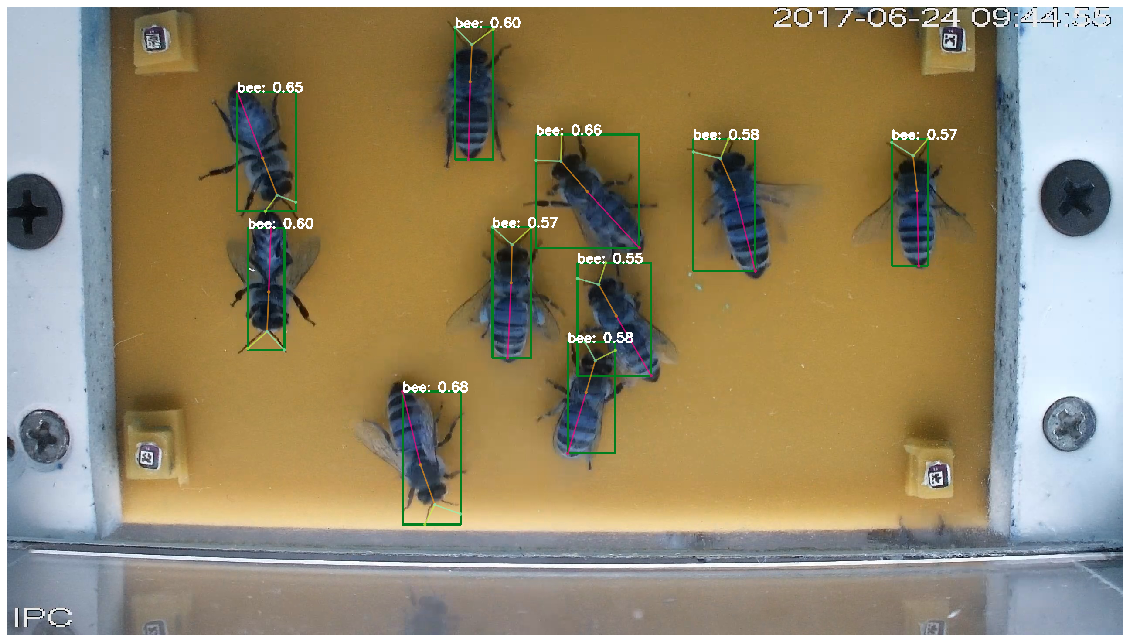

In [98]:
#single mse dp
import matplotlib.gridspec as gridspec
from itertools import chain

data_size = "135"
its = range(500,3501,500)


sr2s = ["standard_res1/1","standard_res1/2","standard_res1/3"]
bla = ["standard_res_f5_.001_1/1","standard_res_f5_.001_1/2","standard_res_f5_.001_1/3"]
bla2 = ["standard_res_lr_.0003_f65_1/1","standard_res_lr_.0003_f65_1/2","standard_res_lr_.0003_f65_1/3"]
cf25 = ["combined_res.001/1","combined_res.001/2","combined_res.001/3"]
cf5 = ["combined_res_f5_.001_.001/1","combined_res_f5_.001_.001/2","combined_res_f5_.001_.001/3"]
cf65 = ["combined_res_lr_.0003_f65_.001/1","combined_res_lr_.0003_f65_.001/2","combined_res_lr_.0003_f65_.001/3"]
cu55 = ["combined_res_f5_un_.001_.001/1","combined_res_f5_un_.001_.001/2","combined_res_f5_un_.001_.001/3"]
cu65 = ["combined_res_un_lr_.0003_f65_.001/1","combined_res_un_lr_.0003_f65_.001/2","combined_res_un_lr_.0003_f65_.001/3"]
loss = cf65[2]
#its = [2000]
for it in its:
    print(it,"it")
    if it < 1000:
        it = "0000" + str(it)
    elif it > 9999:
        it = "00" + str(it)
    else:
        it = "000" + str(it)
    config_file = "/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml"

    cfg.merge_from_file("/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml")
    cfg.merge_from_list(['DATALOADER.NUM_WORKERS', '2', \
                         'DATATYPE', 'bee', \
                         'OUTPUT_DIR', 'training_dir/' + data_size + '/' + loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee1', \
                         'MODEL.WEIGHT', '/home/bsb2144/directpose/tools/training_dir/' + data_size + '/'+ loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee/model_'+it+'.pth',\
                         'DATASETS.TEST', "('bee_val_cocostyle',)",\
                         'DATASETS.TRAIN', "('bee_train_cocostyle', )",\
                        ])

    coco_demo = COCODemo(
                cfg,
                min_image_size=800,
                confidence_threshold=0.2,
    )


    mse_total = []
    tim = [test_images[0]]
    for idx, image in enumerate(test_images):
        mse_per_bee = []
        predictions, tps, hm_res, stride, hms, targets, c_loss = coco_demo.run_on_opencv_image(image)
        kps = tps.get_field("keypoints").keypoints
        bboxes = tps.bbox
        #print("BBOXES", bboxes)
        #print("KPS",kps)
        plt.gca().invert_yaxis()
        imshow(predictions[:, :, [2, 1, 0]])
        plt.gca().invert_yaxis()

        for p in data_an['images'][:]:
            if (str(p['file_name']) == test_files[idx] ):
                im_id = p['id']         
        print(im_id)
        for p in data_an['annotations'][:]:
            if ((p['image_id']) == im_id ):
                #print(p['id'])
                #bb = p["segmentation"]#p['bbox']
                bb = p['bbox']
                #bb = bb[0]
                #print('bb', bb)
                bb_f = [bb[:2], bb[2:4], bb[4:6], bb[6:]]
                #print('bbf', bb_f)
                bbox = bounding_box(bb_f)
                cent_val = get_centroid(bbox)
                dists = []
                #print(cent_val)
                for index, p_bbox in enumerate(bboxes):
                    cp = get_centroid(p_bbox)
                    dist = get_dist(cent_val, cp)
                    dists.append(dist)
                    #print(dist)
                min_idx = dists.index(min(dists))
                #print("min id", min_idx)
                kps_val = p["keypoints"]
                #print('kps val', kps_val)
                # comment for test and remove og
                #kps_val = [x for i, x in enumerate(kps_valog) if (i+1)%3 !=0]
                #print('kps val', kps_val)
                kps_pred = kps[min_idx].tolist()
                kps_pred_list = [kps_pred[0][:2],kps_pred[1][:2],kps_pred[2][:2],kps_pred[3][:2],kps_pred[4][:2]]
                kps_pl = list(chain.from_iterable(kps_pred_list))
                #print("kps val", kps_pred)
                #print("kp pred listt", kps_pred_list)
                diff_vec = np.array(kps_val) - np.array(kps_pl)
                #print(diff_vec)
                #print(diff_vec*diff_vec)
                diff_vec_sum_sq = np.sum(diff_vec*diff_vec)
                #print(diff_vec_sum_sq)
                mse_per_bee.append(diff_vec_sum_sq)

        mse_per_image = sum(mse_per_bee)
        #print("mse", mse_per_image)
        #print("mse", mse_per_bee)
        mse_final = mse_per_image/len(mse_per_bee)
        mse_total.append(mse_final)
        #print("mse final", mse_final)


        #img3 = predictions[:, :, [2, 1, 0]]
        #b,g,r = cv2.split(img3)       # get b,g,r
        #img3 = cv2.merge([r,g,b])     # switch it to rgb
        #im = axes[idx][2].imshow(img3)
        #axes[idx][2].invert_yaxis()
        #plt.savefig(base_file + '_reg.png')
    print("mse total for all images", mse_total)
    print(sum(mse_total))
    mse_test = sum(mse_total)/len(mse_total)
    c_3.append(mse_test)
    print("mse yo", mse_test)


In [99]:
# print(s_1, len(s_1))
# s_1t = [535803.416802767, 190901.3497251098, 9833.224084767102, 12039.002122014794, 10961.347104582734, 10095.452498234004, 9133.592689629197, 7965.038921178797, 7353.186608055335]
# s_2t = [41940.80266502153, 26742.031052376296, 49212.50495121605, 38069.49990734352, 10988.268367740433, 9173.639841072112, 10068.33995907213, 8441.350380823873, 8508.407522488165]
# s_3t = [733913.823681087, 59821.31178167551, 81479.69969149983, 15359.90340421107, 10819.872517237485, 8191.470040645629, 8375.345850782056, 8343.020127062224, 8828.733685820729]
# print(s_2, len(s_2))
# print(s_3, len(s_3))

print(c_1,len(c_1))
print(c_2,len(c_2))
print(c_3,len(c_3))

# print(cu_1,len(cu_1))
# print(cu_2,len(cu_2))
# print(cu_3,len(cu_3))


[12157.324544280398, 15546.258409102713, 8216.04983393748, 10731.127997477026, 8401.923028105666, 6852.660582588136, 6483.0845447532665, 6398.363217784868, 6249.143309733495, 6886.19195743862, 6473.502627360203, 6582.51459470001, 6263.423772042477, 6359.661312085329, 6560.224964622044] 15
[12975.180586249811, 15706.49217029868, 9714.060082448237, 8546.776541874131, 8300.317879325938, 6566.5778847798565, 7468.510230477174, 6158.538061672201, 6858.049640665489, 6386.051939543182, 6333.989518369379, 6178.338919698159, 6354.299012259429, 6732.00109084364, 6414.37408837973] 15
[9949.745635245145, 9008.438230743082, 11311.32539410342, 12888.23992594277, 7707.055767710379, 6268.093937585331, 6231.2146394208485, 7217.644930377803, 6652.151494192511, 7093.189351931366, 5854.358295671202, 6119.038214615647, 5948.027561553581, 5978.227840723977, 6022.090197255181] 15


In [94]:
c_2 = [12975.180586249811, 15706.49217029868, 9714.060082448237, 8546.776541874131, 8300.317879325938, 6566.5778847798565, 7468.510230477174, 6158.538061672201]
c_3 = [9949.745635245145, 9008.438230743082, 11311.32539410342, 12888.23992594277, 7707.055767710379, 6268.093937585331, 6231.2146394208485, 7217.644930377803]

In [29]:
s_avg = []
s_diff = []
for s1, s2, s3 in zip(s_1,s_2,s_3):
    sa = (s1+s2+s3)/3
    d1 = abs(s1 - sa)
    d2 = abs(s2-sa)
    d3 = abs(s3-sa)
    di = [d1,d2,d3]
    s_diff.append(max(di))
    s_avg.append(sa)
    
print(s_avg)
print(s_diff)

[437219.34771629184, 92488.23085305386, 46841.809575827654, 21822.801811189795, 10923.162663186884, 9153.520793317248, 9192.426166494459, 8249.80314302163, 8230.10927212141, 6751.885943665278, 6696.747107391219, 7275.393702714949, 6543.547721066442, 6343.633671641489, 6360.950966863686, 6270.5444143549, 6431.473046334358, 6637.531697550505, 6725.050384006729]
[395278.5450512703, 98413.11887205593, 37008.585491060556, 16246.698096153723, 103.29014594939872, 962.0507526716192, 875.9137925776704, 284.76422184283365, 876.9226640660754, 179.4237333617457, 143.53495863542685, 1256.2189638206446, 237.73449932295443, 245.03646285647392, 473.1250949860432, 217.67686021915506, 156.02219186436923, 701.5525528972776, 463.91925018846086]


In [100]:
c_avg = []
c_diff = []
for s1, s2, s3 in zip(c_1,c_2,c_3):
    sa = (s1+s2+s3)/3
    d1 = abs(s1 - sa)
    d2 = abs(s2-sa)
    d3 = abs(s3-sa)
    di = [d1,d2,d3]
    c_diff.append(max(di))
    c_avg.append(sa)
    
print(c_avg)
print(c_diff)
print(len(c_avg))

[11694.083588591786, 13420.396270048159, 9747.14510349638, 10722.048155097975, 8136.432225047327, 6562.444134984441, 6727.603138217096, 6591.515403278291, 6586.448148197164, 6788.477749637724, 6220.616813800261, 6293.297243004606, 6188.583448618495, 6356.630081217649, 6332.229750085651]
[1744.3379533466414, 4411.958039305076, 1564.1802906070407, 2175.271613223844, 429.3764573369481, 294.3501973991097, 740.9070922600786, 626.1295270995115, 337.3048384636695, 402.4258100945417, 366.25851812905967, 289.21735169540443, 240.5558870649138, 378.40224049367134, 310.13955283047017]
15


In [70]:
cu_avg = []
cu_diff = []
for s1, s2, s3 in zip(cu_1,cu_2,cu_3):
    sa = (s1+s2+s3)/3
    d1 = abs(s1 - sa)
    d2 = abs(s2-sa)
    d3 = abs(s3-sa)
    di = [d1,d2,d3]
    cu_diff.append(max(di))
    cu_avg.append(sa)
    
print(cu_avg)
print(cu_diff)

[6782.670575991688, 6677.004249076469, 7560.067717470726, 6369.186529813502, 6651.781383001674, 6600.920716568707, 6501.04789952609, 6527.831693400397, 6667.52445592272, 6441.743011765578]
[704.3606348992598, 665.1355394753455, 792.1620024686645, 124.54501305275517, 383.6231485640237, 666.3250145909396, 719.0744890901633, 502.0546150008249, 830.5662500328235, 605.06931991904]


In [60]:
import numpy as np
bu = np.array([7200])
bu = (np.repeat(bu, 19, axis=0)).tolist()
print(bu)
td = np.array([6900])
td = np.repeat(td, 19, axis=0).tolist()
print(td)

[7200, 7200, 7200, 7200, 7200, 7200, 7200, 7200, 7200, 7200, 7200, 7200, 7200, 7200, 7200, 7200, 7200, 7200, 7200]
[6900, 6900, 6900, 6900, 6900, 6900, 6900, 6900, 6900, 6900, 6900, 6900, 6900, 6900, 6900, 6900, 6900, 6900, 6900]


In [ ]:
it7 = range(3500,10001,500)
#it7=it5[2:]
#it_c = range(3000,10001,500)
#it2 = range(8000,10001,500)
#it3 = range(9500,10001,500)
it1 = range(3500,10001,500)
it2 = range(5500,10001,500)
fig, axes = plt.subplots(1,1,figsize=(16,8))
ax = axes
ax.title.set_text("Test MSE: trained on rescaled")
colors = ['r','b','y','g']

#plt.plot(it7, s_avg[5:], '-o', c='orange', label="standard lr=.01,lr=.001,lr=.0003")
plt.errorbar(it7, s_avg[5:], yerr=s_diff[5:], xerr=None, fmt='', ecolor='grey',c='grey',label="standard lr=.01,lr=.001,lr=.0003"
            ,elinewidth=None, capsize=16, capthick=3)
plt.errorbar(it1, c_avg[1:], yerr=c_diff[1:], xerr=None, fmt='', ecolor='blue',c='blue',label="combined lr=.01,lr=.001,lr=.0003",capsize=16, capthick=3)
plt.errorbar(it2, cu_avg, yerr=cu_diff, xerr=None, fmt='', ecolor='purple',c='purple',label="combined with unlabeled  lr=.01,lr=.001,lr=.0003",capsize=16, capthick=3)
#plt.plot(it1, c_avg[1:], '-o', c='blue', label="combined lr=.01,lr=.001,lr=.0003")
#plt.plot(it2, cu_avg, '-o', c='purple', label="combined with unlabeled  lr=.01,lr=.001,lr=.0003")


#plt.plot(it7, small_c,'-o', c='blue', label="combined")
plt.plot(it7, bu[0:14],'-o', c='red', label="bottom up")
plt.plot(it7, td[0:14],'-o', c='green', label="top down")
    
fig.legend(loc='upper left')
fig.savefig("combo_st_sleap_un2" +'.png')
plt.show()